# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откроем файл с данными и изучим общую информацию. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1          11.0      2.0   посёлок Шушары           12817.0   
2           8.3      0.0  Санкт-Петербург           21741.0   
3           NaN      0.0  Санкт-Петербург           28098.0   
4          41.0      NaN  Санкт-Петербург           31856.0   

  cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0             16028.0               1.0          482.0               2.0   
1             18603.0               0.0            NaN               0.0   
2             13933.0               1.0           90.0               2.0   
3              6800.0               2.0           84.0               3.0   
4              8098.0               2.0          112.0               1.0   

   ponds_nearest  days_exposition  
0          755.0              NaN  
1            NaN             81.0  
2          574.0            558.0  
3          234.0            424.0  
4           48.0            121.0  

[5 rows x 22 columns]

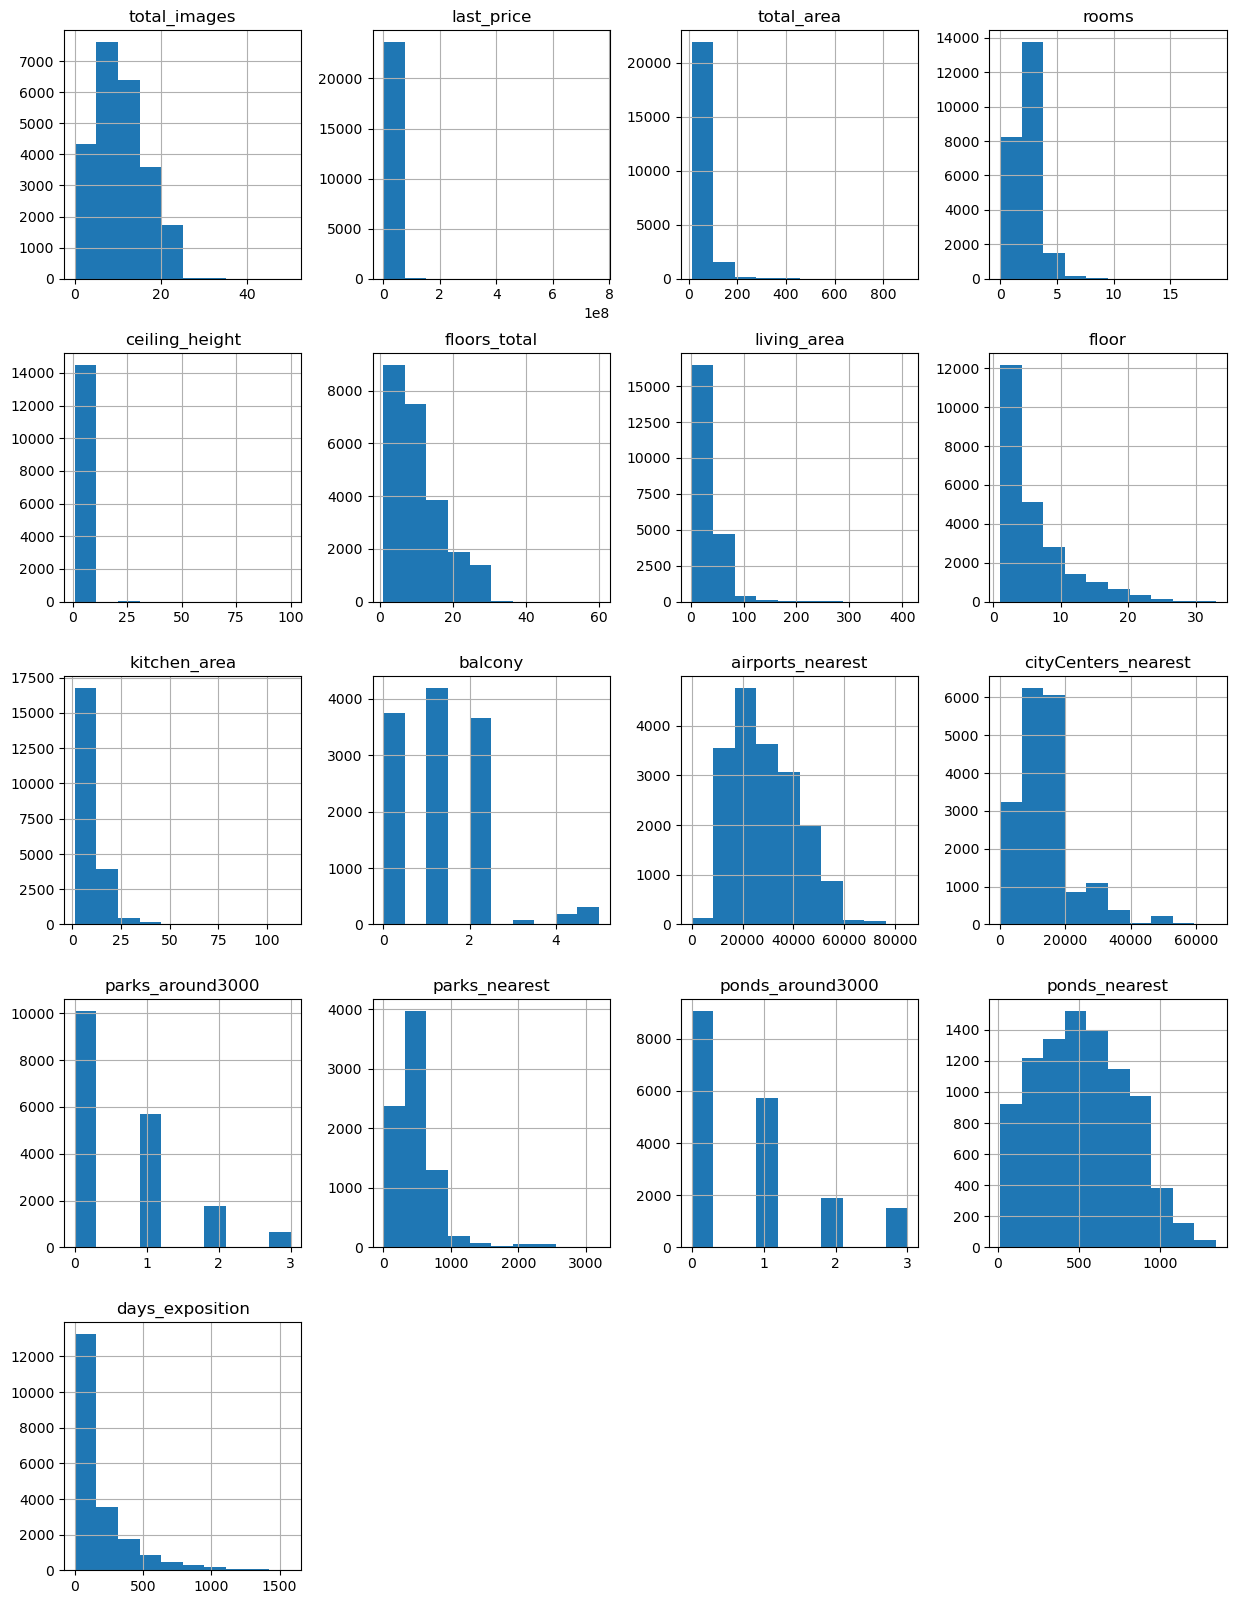

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('datasets/real_estate_data.csv', sep="\t")

data.info()
display(data.head())
data.hist(figsize=(15, 20));

### Предобработка данных

Проверим данные на количество пропусков

In [2]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Столбец 'ceiling_height' — высота потолков в метрах. Вероятная причина — незаполнение данных. Удаление пустых строк может существено повлиять на результаты исследования. Заменим незаполненые данные медианным значением

In [3]:
print(f"Количество пропущенных значений: {data['ceiling_height'].isna().sum()} шт.")
print(f"Процент пропущенных значений: {data['ceiling_height'].isna().sum()/len(data['ceiling_height'])*100 :.1f} %")
print(f"Медианное значение: {data['ceiling_height'].median() :.2f} метра")

Количество пропущенных значений: 9195 шт.
Процент пропущенных значений: 38.8 %
Медианное значение: 2.65 метра


In [4]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
print(f"Пропущенные значения после замены: {data['ceiling_height'].isna().sum()}")

Пропущенные значения после замены: 0


Столбец 'floors_total' — количество этажей в доме. Вероятная причина — незаполнение данных. Заполнить пропуски медианными значениями в данном случае будет некорректно, так как медианное значение — 9 этаж, но пропуски есть в строках, где этаж квартиры указан больше 9. Удаление пустых строк не может существено повлиять на результаты исследования. Так же данный столбец имеет тип данных 'float64' (число с плавающей точкой), что не верно для количества этажей. Заменим тип данных на 'int' (целое число)

In [5]:
print(f"Количество пропущенных значений: {data['floors_total'].isna().sum()} шт.")
print(f"Процент пропущенных значений: {data['floors_total'].isna().sum()/len(data['floors_total'])*100 :.1f} %")
print(f"Медианное значение: {data['floors_total'].median() :.0f} этажей")

Количество пропущенных значений: 86 шт.
Процент пропущенных значений: 0.4 %
Медианное значение: 9 этажей


In [6]:
data = data.dropna(subset=['floors_total'])
data['floors_total'] = data['floors_total'].astype(int)
print(f"Пропущенные значения после удаления: {data['floors_total'].isna().sum()}")
print('Убедимся, что тип данных изменился:')
data['floors_total'].head()

Пропущенные значения после удаления: 0
Убедимся, что тип данных изменился:


0    16
1    11
2     5
3    14
4    14
Name: floors_total, dtype: int32

Столбец 'living_area' — жилая площадь в квадратных метрах. Вероятная причина — незаполнение данных. Удаление пустых строк может повлиять на результаты исследования. Заменим незаполненые данные медианным значением

In [7]:
print(f"Количество пропущенных значений: {data['living_area'].isna().sum()} шт.")
print(f"Процент пропущенных значений: {data['living_area'].isna().sum()/len(data['living_area'])*100 :.1f} %")
print(f"Медианное значение: {data['living_area'].median() :.2f} м\u00B2")

Количество пропущенных значений: 1870 шт.
Процент пропущенных значений: 7.9 %
Медианное значение: 30.00 м²


In [8]:
data['living_area'] = data['living_area'].fillna(data['living_area'].median())
print(f"Пропущенные значения после замены: {data['living_area'].isna().sum()}")

Пропущенные значения после замены: 0


Столбец 'is_apartment' — апартаменты (да/нет). Вероятная причина — незаполнение данных. Удаление пустых строк может существено повлиять на результаты исследования. Скорее всего, пропущеные значения не были заполнены по причине незнания понятия "апартаменты" и обозначают обычную квартиру (не апартаменты). Заменим незаполненые данные значением False. Так как столбец состоит из булевых значений - изменим тип данных на 'bool'

In [9]:
print(f"Количество пропущенных значений: {data['is_apartment'].isna().sum()} шт.")
print(f"Процент пропущенных значений: {data['is_apartment'].isna().sum()/len(data['is_apartment'])*100 :.1f} %")

Количество пропущенных значений: 20838 шт.
Процент пропущенных значений: 88.2 %


In [10]:
data['is_apartment'] = data['is_apartment'].fillna(False).astype(bool)
print(f"Пропущенные значения после замены: {data['is_apartment'].isna().sum()}")
print('Убедимся что тип данных изменился:')
data['is_apartment'].head()

Пропущенные значения после замены: 0
Убедимся что тип данных изменился:


0    False
1    False
2    False
3    False
4    False
Name: is_apartment, dtype: bool

Столбец 'kitchen_area' — площадь кухни в квадратных метрах. Вероятная причина — незаполнение данных. Удаление пустых строк может повлиять на результаты исследования. Заменим незаполненые данные медианным значением

In [11]:
print(f"Количество пропущенных значений: {data['kitchen_area'].isna().sum()} шт.")
print(f"Процент пропущенных значений: {data['kitchen_area'].isna().sum()/len(data['kitchen_area'])*100 :.1f} %")
print(f"Медианное значение: {data['kitchen_area'].median() :.1f} м\u00B2")

Количество пропущенных значений: 2231 шт.
Процент пропущенных значений: 9.4 %
Медианное значение: 9.1 м²


In [12]:
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())
print(f"Пропущенные значения после замены: {data['kitchen_area'].isna().sum()}")

Пропущенные значения после замены: 0


Столбец 'balcony' — число балконов. Вероятная причина — незаполнение данных. Удаление пустых строк может существенно повлиять на результаты исследования. Скорее всего, заполняющий форму посчитал этот параметр не обязательным к заполнению по причине отсутствия балкона. Заменим незаполненые данные значением 0. Так как количество балконов не может быть равно дробному числу, то заменим тип данных на 'целое число'

In [13]:
print(f"Количество пропущенных значений: {data['balcony'].isna().sum()} шт.")
print(f"Процент пропущенных значений: {data['balcony'].isna().sum()/len(data['balcony'])*100 :.1f} %")

Количество пропущенных значений: 11480 шт.
Процент пропущенных значений: 48.6 %


In [14]:
data['balcony'] = data['balcony'].fillna(0).astype(int)
print(f"Пропущенные значения после замены: {data['balcony'].isna().sum()}")
print('Убедимся что тип данных изменился:')
data['balcony'].head()

Пропущенные значения после замены: 0
Убедимся что тип данных изменился:


0    0
1    2
2    0
3    0
4    0
Name: balcony, dtype: int32

Столбец 'locality_name' — название населённого пункта. Вероятная причина — незаполнение данных. Удаление пустых строк не может существенно повлиять на результаты исследования

In [15]:
print(f"Количество пропущенных значений: {data['locality_name'].isna().sum()} шт.")
print(f"Процент пропущенных значений: {data['locality_name'].isna().sum()/len(data['locality_name'])*100 :.1f} %")

Количество пропущенных значений: 48 шт.
Процент пропущенных значений: 0.2 %


In [16]:
data = data.dropna(subset=['locality_name'])
print(f"Пропущенные значения после удаления: {data['locality_name'].isna().sum()}")

Пропущенные значения после удаления: 0


Столбец 'airports_nearest' — расстояние до ближайшего аэропорта в метрах. Вероятная причина — либо ошибка при выгрузке данных, либо, так как параметр картографический, скорее всего произошла ошибка определения локации. Удаление пустых строк может существенно повлиять на результаты исследования. Замена пропусков медианными значениями может привести к неточности исследования. Создадим новый вспомогательный столбец 'airports_nearest_TorF' (True or False) и запишем в него 1 если значение указано, 0 если пропуск. Пропуски в оригинальном столбце оставим без изменения

In [17]:
print(f"Количество пропущенных значений: {data['airports_nearest'].isna().sum()} шт.")
print(f"Процент пропущенных значений: {data['airports_nearest'].isna().sum()/len(data['airports_nearest'])*100 :.1f} %")

Количество пропущенных значений: 5524 шт.
Процент пропущенных значений: 23.4 %


In [18]:
data['airports_nearest_TorF'] = pd.notna(data['airports_nearest']).astype(int)
print(f"Пропущенные значения после замены в оригинальном столбце: {data['airports_nearest'].isna().sum()}")    
print(f"Пропущенные значения после замены во вспомогательном столбце: {data['airports_nearest_TorF'].isna().sum()}")   

Пропущенные значения после замены в оригинальном столбце: 5524
Пропущенные значения после замены во вспомогательном столбце: 0


Столбец 'cityCenters_nearest' — расстояние до центра города в метрах. Вероятная причина — либо ошибка при выгрузке данных, либо, так как параметр картографический, скорее всего произошла ошибка определения локации. Удаление пустых строк может существенно повлиять на результаты исследования. Замена пропусков медианными значениями может привести к неточности исследования. Создадим новый вспомогательный столбец 'cityCenters_nearest_TorF' (True or False) и запишем в него 1 если значение указано, 0 если пропуск. Пропуски в оригинальном столбце оставим без изменения

In [19]:
print(f"Количество пропущенных значений: {data['cityCenters_nearest'].isna().sum()} шт.")
print(f"Процент пропущенных значений: {data['cityCenters_nearest'].isna().sum()/len(data['cityCenters_nearest'])*100 :.1f} %")

Количество пропущенных значений: 5501 шт.
Процент пропущенных значений: 23.3 %


In [20]:
data['cityCenters_nearest_TorF'] = pd.notna(data['cityCenters_nearest']).astype(int)
print(f"Пропущенные значения после замены в оригинальном столбце: {data['cityCenters_nearest'].isna().sum()}")    
print(f"Пропущенные значения после замены во вспомогательном столбце: {data['cityCenters_nearest_TorF'].isna().sum()}")  

Пропущенные значения после замены в оригинальном столбце: 5501
Пропущенные значения после замены во вспомогательном столбце: 0


Столбец 'parks_around3000' — число парков в радиусе 3 км. Вероятная причина — либо ошибка при выгрузке данных, либо так как параметр картографический, скорее всего произошла ошибка определения локации. Удаление пустых строк может существенно повлиять на результаты исследования. Замена пропусков медианными значениями может привести к неточности исследования. Создадим новый вспомогательный столбец 'parks_around3000_TorF' (True or False) и запишем в него 1 если значение указано, 0 если пропуск. Пропуски в оригинальном столбце оставим без изменения

In [21]:
print(f"Количество пропущенных значений: {data['parks_around3000'].isna().sum()} шт.")
print(f"Процент пропущенных значений: {data['parks_around3000'].isna().sum()/len(data['parks_around3000'])*100 :.1f} %")

Количество пропущенных значений: 5500 шт.
Процент пропущенных значений: 23.3 %


In [22]:
data['parks_around3000_TorF'] = pd.notna(data['parks_around3000']).astype(int)
print(f"Пропущенные значения после замены в оригинальном столбце: {data['parks_around3000'].isna().sum()}")    
print(f"Пропущенные значения после замены во вспомогательном столбце: {data['parks_around3000_TorF'].isna().sum()}")  

Пропущенные значения после замены в оригинальном столбце: 5500
Пропущенные значения после замены во вспомогательном столбце: 0


Столбец 'parks_nearest' — расстояние до ближайшего парка в метрах. Вероятная причина — либо ошибка при выгрузке данных, либо, так как параметр картографический, скорее всего произошла ошибка определения локации. Удаление пустых строк может существенно повлиять на результаты исследования. Замена пропусков медианными значениями может привести к неточности исследования. Создадим новый вспомогательный столбец 'parks_nearest_TorF' (True or False) и запишем в него 1 если значение указано, 0 если пропуск. Пропуски в оригинальном столбце оставим без изменения

In [23]:
print(f"Количество пропущенных значений: {data['parks_nearest'].isna().sum()} шт.")
print(f"Процент пропущенных значений: {data['parks_nearest'].isna().sum()/len(data['parks_nearest'])*100 :.1f} %")

Количество пропущенных значений: 15535 шт.
Процент пропущенных значений: 65.9 %


In [24]:
data['parks_nearest_TorF'] = pd.notna(data['parks_nearest']).astype(int)
print(f"Пропущенные значения после замены в оригинальном столбце: {data['parks_nearest'].isna().sum()}")    
print(f"Пропущенные значения после замены во вспомогательном столбце: {data['parks_nearest_TorF'].isna().sum()}")  

Пропущенные значения после замены в оригинальном столбце: 15535
Пропущенные значения после замены во вспомогательном столбце: 0


Столбец 'ponds_around3000' — число водоёмов в радиусе 3 км. Вероятная причина — либо ошибка при выгрузке данных, либо так как параметр картографический, скорее всего произошла ошибка определения локации. Удаление пустых строк может существенно повлиять на результаты исследования. Замена пропусков медианными значениями может привести к неточности исследования. Создадим новый вспомогательный столбец 'ponds_around3000_TorF' (True or False) и запишем в него 1 если значение указано, 0 если пропуск. Пропуски в оригинальном столбце оставим без изменения

In [25]:
print(f"Количество пропущенных значений: {data['ponds_around3000'].isna().sum()} шт.")
print(f"Процент пропущенных значений: {data['ponds_around3000'].isna().sum()/len(data['ponds_around3000'])*100 :.1f} %")

Количество пропущенных значений: 5500 шт.
Процент пропущенных значений: 23.3 %


In [26]:
data['ponds_around3000_TorF'] = pd.notna(data['ponds_around3000']).astype(int)
print(f"Пропущенные значения после замены в оригинальном столбце: {data['ponds_around3000'].isna().sum()}")    
print(f"Пропущенные значения после замены во вспомогательном столбце: {data['ponds_around3000_TorF'].isna().sum()}")  

Пропущенные значения после замены в оригинальном столбце: 5500
Пропущенные значения после замены во вспомогательном столбце: 0


Столбец 'ponds_nearest' — расстояние до ближайшего водоёма в метрах. Вероятная причина — либо ошибка при выгрузке данных, либо так как параметр картографический, скорее всего произошла ошибка определения локации. Удаление пустых строк может существенно повлиять на результаты исследования. Замена пропусков медианными значениями может привести к неточности исследования. Создадим новый вспомогательный столбец 'ponds_nearest_TorF' (True or False) и запишем в него 1 если значение указано, 0 если пропуск. Пропуски в оригинальном столбце оставим без изменения

In [27]:
print(f"Количество пропущенных значений: {data['ponds_nearest'].isna().sum()} шт.")
print(f"Процент пропущенных значений: {data['ponds_nearest'].isna().sum()/len(data['ponds_nearest'])*100 :.1f} %")

Количество пропущенных значений: 14529 шт.
Процент пропущенных значений: 61.7 %


In [28]:
data['ponds_nearest_TorF'] = pd.notna(data['ponds_nearest']).astype(int)
print(f"Пропущенные значения после замены в оригинальном столбце: {data['ponds_nearest'].isna().sum()}")    
print(f"Пропущенные значения после замены во вспомогательном столбце: {data['ponds_nearest_TorF'].isna().sum()}")  

Пропущенные значения после замены в оригинальном столбце: 14529
Пропущенные значения после замены во вспомогательном столбце: 0


Столбец 'days_exposition' — сколько дней было размещено объявление (от публикации до снятия). Вероятная причина — объявление еще не снято с публикации. Удаление пустых строк может повлиять на результаты исследования. Замена пропусков медианными значениями может привести к неточности исследования. Создадим новый вспомогательный столбец 'ponds_nearest_TorF' (True or False) и запишем в него 1 если значение указано, 0 если пропуск. Пропуски в оригинальном столбце оставим без изменения

In [29]:
print(f"Количество пропущенных значений: {data['days_exposition'].isna().sum()} шт.")
print(f"Процент пропущенных значений: {data['days_exposition'].isna().sum()/len(data['days_exposition'])*100 :.1f} %")

Количество пропущенных значений: 3171 шт.
Процент пропущенных значений: 13.5 %


In [30]:
data['days_exposition_TorF'] = pd.notna(data['days_exposition']).astype(int)
print(f"Пропущенные значения после замены в оригинальном столбце: {data['days_exposition'].isna().sum()}")    
print(f"Пропущенные значения после замены во вспомогательном столбце: {data['days_exposition_TorF'].isna().sum()}")  

Пропущенные значения после замены в оригинальном столбце: 3171
Пропущенные значения после замены во вспомогательном столбце: 0


Столбец 'first_day_exposition' — дата публикации имеет тип данных object. Так как это столбец с датой, то изменим тип данных на datatime

In [31]:
data['first_day_exposition']=pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S.%f')
print('Убедимся что тип данных изменился:')
print(data['first_day_exposition'].head())

Убедимся что тип данных изменился:
0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]


Изучим уникальные значения в столбце 'locality_name' и устраним неявные дубликаты, так как один и тот же населенный пункт может быть записан по разному

In [32]:
data['locality_name'] = data['locality_name'].str.lower()

print('Количество уникальных названий:', len(data['locality_name'].unique()))
print()

checked = set()
for s in data['locality_name'].unique():
    name = s.split(' ')[-1]
    if name != '' and not name in checked:
        checked.add(name)
        ss = data[data['locality_name'].str.contains(name)]['locality_name'].unique()
        if len(ss)>1:
            print(ss)

Количество уникальных названий: 364

['городской посёлок янино-1' 'городской поселок янино-1']
['посёлок мурино' 'поселок мурино' 'мурино']
['деревня кудрово' 'кудрово']
['коммунар' 'поселок коммунары']
['поселок городского типа красный бор' 'выборг' 'сосновый бор'
 'посёлок городского типа красный бор' 'деревня чудской бор' 'деревня бор'
 'деревня трубников бор' 'посёлок пансионат зелёный бор'
 'поселок пансионат зелёный бор' 'деревня борисова грива']
['деревня фёдоровское' 'городской посёлок фёдоровское']
['посёлок городского типа лебяжье' 'поселок городского типа лебяжье']
['поселок городского типа кузьмоловский'
 'посёлок городского типа кузьмоловский']
['садовое товарищество новая ропша' 'посёлок ропша']
['кингисепп' 'поселок кингисеппский']
['посёлок аннино' 'поселок аннино']
['поселок городского типа красный бор' 'поселок мурино'
 'поселок молодцово' 'поселок городского типа кузьмоловский'
 'поселок городского типа ефимовский' 'поселок торковичи'
 'поселок первомайское' 'красное

Достаточно большой объем неявных дубликатов связан с буквами 'Е' и 'Ё' в слове 'поселок' и написании 'поселок городского типа' как 'городской поселок'. Для начала приведем данные слова к одному виду, чтобы уменьшить список неявных дубликатов

In [33]:
data['locality_name'] = data['locality_name'].str.replace('посёлок', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок городского типа')

print('Количество уникальных названий:', len(data['locality_name'].unique()))
print()

checked = set()
for s in data['locality_name'].unique():
    name = s.split(' ')[-1]
    if name != '' and not name in checked:
        checked.add(name)
        ss = data[data['locality_name'].str.contains(name)]['locality_name'].unique()
        if len(ss)>1:
            print(ss)

Количество уникальных названий: 323

['поселок мурино' 'мурино']
['деревня кудрово' 'кудрово']
['коммунар' 'поселок коммунары']
['поселок городского типа красный бор' 'выборг' 'сосновый бор'
 'деревня чудской бор' 'деревня бор' 'деревня трубников бор'
 'поселок пансионат зелёный бор' 'деревня борисова грива']
['деревня фёдоровское' 'поселок городского типа фёдоровское']
['садовое товарищество новая ропша' 'поселок ропша']
['кингисепп' 'поселок кингисеппский']
['поселок шушары' 'поселок городского типа янино-1' 'поселок парголово'
 'поселок мурино' 'поселок городского типа красный бор'
 'поселок металлострой' 'поселок городского типа лебяжье'
 'поселок городского типа сиверский' 'поселок молодцово'
 'поселок городского типа кузьмоловский' 'поселок аннино'
 'поселок городского типа ефимовский' 'поселок плодовое'
 'поселок торковичи' 'поселок первомайское' 'красное село'
 'поселок понтонный' 'поселок новый свет' 'село путилово'
 'поселок романовка' 'поселок бугры' 'поселок городского типа

Неявные дубликаты, найденные в столбце 'locality_name', которые нужно привести к одному виду:
* 'поселок мурино', 'мурино' (заменить на 'поселок мурино')
* 'деревня кудрово', 'кудрово' (заменить на 'деревня кудрово')
* 'деревня фёдоровское', 'поселок городского типа фёдоровское' (заменить на ''поселок городского типа фёдоровское')
* 'никольское', 'село никольское' (заменить на 'село никольское')
* 'поселок рябово', 'поселок городского типа рябово' (заменить на 'поселок городского типа рябово')
* 'поселок станции вещево', 'поселок при железнодорожной станции вещево' (заменить на 'поселок при железнодорожной станции вещево')
* 'деревня гарболово', 'поселок гарболово' (заменить на 'деревня гарболово')
* 'поселок станции приветнинское', 'поселок при железнодорожной станции приветнинское' (заменить на 'поселок при железнодорожной станции приветнинское')




In [34]:
data.loc[data['locality_name'] == "мурино", 'locality_name'] = 'поселок мурино'
data.loc[data['locality_name'] == "кудрово", 'locality_name'] = 'деревня кудрово'
data.loc[data['locality_name'] == "деревня фёдоровское", 'locality_name'] = 'поселок городского типа фёдоровское'
data.loc[data['locality_name'] == "никольское", 'locality_name'] = 'село никольское'
data.loc[data['locality_name'] == "поселок рябово", 'locality_name'] = 'поселок городского типа рябово'
data.loc[data['locality_name'] == "поселок станции вещево", 'locality_name'] = 'поселок при железнодорожной станции вещево'
data.loc[data['locality_name'] == "поселок гарболово", 'locality_name'] = 'деревня гарболово'
data.loc[data['locality_name'] == "поселок станции приветнинское", 
         'locality_name'] = 'поселок при железнодорожной станции приветнинское'

print('Количество уникальных названий:', len(data['locality_name'].unique()))
print()



Количество уникальных названий: 315



Изучим данные на наличие аномалий

count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64

<AxesSubplot:ylabel='Frequency'>

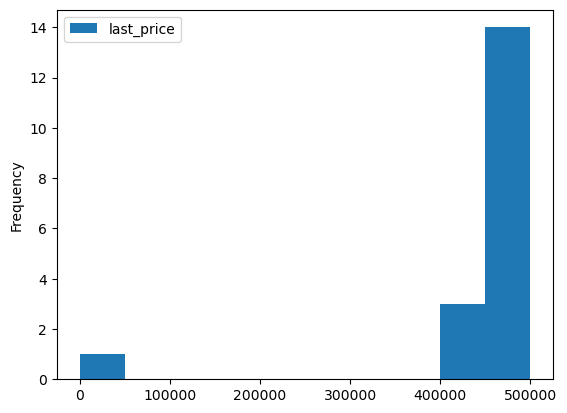

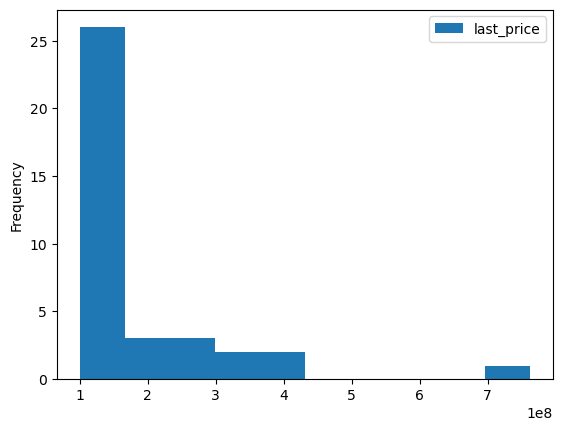

In [35]:
display(data['last_price'].describe())
data.plot(kind='hist', y='last_price', range=(0,500000))
data.plot(kind='hist', y='last_price', range=(1e+08,7.630000e+08))

In [36]:
display(data.loc[data['last_price'] < 499000, ['locality_name', 'last_price', 'total_area']])
data.loc[data['last_price'] > 500000000, ['locality_name', 'last_price', 'total_area']]

locality_name  last_price  total_area
5698   поселок городского типа будогощь    450000.0        42.0
6859                 деревня старополье    490000.0        40.0
8793                    санкт-петербург     12190.0       109.0
9581                 деревня старополье    450000.0        43.4
10782                            сланцы    490000.0        29.1
14911             поселок станции свирь    430000.0        54.0
16032                            сланцы    480000.0        32.0
16219              деревня вахнова кара    450000.0        38.5
16274                деревня старополье    440000.0        40.0
17456                            сланцы    430000.0        30.4
17676                 деревня ям-тесово    450000.0        36.5
18867                  деревня выскатка    470000.0        41.0
21912                 поселок совхозный    470000.0        37.0
23484                            сланцы    470000.0        44.5

locality_name   last_price  total_area
12971  санкт-петербург  763000000.0       400.0

Судя по гистограмме цена 763 млн. выглядит как аномалия, но такая стоимость за квартиру в 400 $м^2$ в Санкт-Петербурге вполне реальна. Потому считаем, что по максимальной цене аномалий нет

По минимальной цене выбивается значение цены 12190 за квартиру 109 $м^2$ в Санкт-Петербурге. Вероятнее всего при заполнении данных посчитали что цена указывается в 'тыс. рублей', соответственно имелось в виду 12 млн. 190 тыс., что вполне реальная стоимость для данного варианта. Но так как аномалия присутствует только в одной строке и ее удаление не повлияет на ислледование, то лучше удалить данную строку, чем заменять на предполагаемое значение

In [37]:
data = data[data['last_price'] > 12190]
print('Проверим цены еще раз, убедимся что избавились от аномалии:')
display(data.loc[data['last_price'] < 499000, ['locality_name', 'last_price', 'total_area']])

Проверим цены еще раз, убедимся что избавились от аномалии:


locality_name  last_price  total_area
5698   поселок городского типа будогощь    450000.0        42.0
6859                 деревня старополье    490000.0        40.0
9581                 деревня старополье    450000.0        43.4
10782                            сланцы    490000.0        29.1
14911             поселок станции свирь    430000.0        54.0
16032                            сланцы    480000.0        32.0
16219              деревня вахнова кара    450000.0        38.5
16274                деревня старополье    440000.0        40.0
17456                            сланцы    430000.0        30.4
17676                 деревня ям-тесово    450000.0        36.5
18867                  деревня выскатка    470000.0        41.0
21912                 поселок совхозный    470000.0        37.0
23484                            сланцы    470000.0        44.5

In [38]:
print(data['total_area'].describe())
display(data.loc[data['total_area'] < 15, ['locality_name', 'last_price', 'total_area']])
display(data.loc[data['total_area'] > 500, ['locality_name', 'last_price', 'total_area']])

count    23564.000000
mean        60.320758
std         35.656406
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64


locality_name  last_price  total_area
17961  санкт-петербург   1400000.0        13.0
19546  санкт-петербург   1850000.0        13.0
19558  санкт-петербург   1686000.0        13.2
19642  санкт-петербург   1190000.0        14.0
19807  санкт-петербург   3800000.0        13.0
19904  санкт-петербург   2400000.0        12.0

locality_name   last_price  total_area
3117   санкт-петербург  140000000.0       631.0
4237   санкт-петербург   50000000.0       517.0
5358   санкт-петербург   65000000.0       590.0
8018   санкт-петербург   84000000.0       507.0
12859  санкт-петербург  140000000.0       631.2
15651  санкт-петербург  300000000.0       618.0
19540  санкт-петербург  420000000.0       900.0

В столбце 'total_area' аномалий не найдено

In [39]:
print(data['rooms'].describe())

display(data.loc[data['rooms'] == 0, ['rooms', 'studio', 'total_area', 'locality_name', 'kitchen_area']].head())
print(f"Количество значений равных нулю: {len(data[data['rooms'] == 0])} шт.")
print(f"Процент значений равных нулю: {len(data[data['rooms'] == 0])/len(data['rooms'])*100 :.1f} %")

data['temp_index'] = (data['studio'] == 0) & (
    ((data['rooms'] == 1) & (data['total_area'] - data['kitchen_area'] < 14)) | (
        (data['rooms'] > 1) & (data['total_area'] - data['kitchen_area'] - 16 < 9)))

display(data.loc[data['temp_index']==1, ['rooms', 'studio','total_area', 'locality_name', 'kitchen_area']])
print(f"Количество значений с комнатами не по нормам: {len(data[data['temp_index']==1])} шт.")
print(f"Процент значений с комнатами не по нормам: {len(data[data['temp_index']==1])/len(data['rooms'])*100 :.1f} %")

count    23564.000000
mean         2.070659
std          1.078613
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


rooms  studio  total_area      locality_name  kitchen_area
144      0    True       27.00     поселок мурино           9.1
349      0   False       25.00    деревня кудрово           9.1
440      0    True       27.11    санкт-петербург           9.1
508      0   False       34.40  поселок парголово           9.1
608      0    True       25.00     поселок шушары           9.1

Количество значений равных нулю: 194 шт.
Процент значений равных нулю: 0.8 %


C:\Users\User\AppData\Local\Temp\ipykernel_20004\3406547814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['temp_index'] = (data['studio'] == 0) & (


rooms  studio  total_area    locality_name  kitchen_area
696        1   False       34.69  санкт-петербург         23.43
874        2   False       33.00  санкт-петербург          9.10
1194       1   False       22.70  санкт-петербург          9.10
1280       1   False       23.00   поселок мурино          9.10
1326       2   False       52.00  санкт-петербург         32.00
...      ...     ...         ...              ...           ...
21802      1   False       17.78  санкт-петербург          9.10
21981      1   False       21.57   поселок мурино          9.10
22356      1   False       17.20  санкт-петербург          9.10
22473      2   False       33.26  санкт-петербург         16.40
23191      1   False       18.90            тосно          9.10

[90 rows x 5 columns]

Количество значений с комнатами не по нормам: 90 шт.
Процент значений с комнатами не по нормам: 0.4 %


В столбце 'rooms' присутствует аномалии:
* Количество комнат равно 0. Вероятнее всего ошибка заполнения, например, в случае если квартира является студией ('studio' = True) человек, заполняющий данные мог посчитать, что в его случае комнат нет
* Количество комнат не соответствует площади: "Согласно требованиям СП 54.13330.2011 площадь жилой комнаты не может быть менее 9 $м^2$ при условии, что в квартире есть еще одна жилая комната площадью 16 $м^2$. Для однокомнатной же квартиры площадь единственной комнаты не может быть менее 14 $м^2$". Соответственно в строках, не соответствующих этим условиям, либо ошибка, либо данные заполнены про квартиры с незаконной перепланировкой (что не подходит для нашего исследования)
<br>
<br>
Аномальных значений в первом случае всего 0.8 %, во втором случае - 0,4 % <br>
Удаление строк с аномалиями не может существенно повлиять на результаты исследования

In [40]:
data = data[data['rooms'] != 0]
data = data[data['temp_index'] == 0]
print(f"Количество значений равных нулю: {len(data[data['rooms'] == 0])} шт.")
print(f"Количество значений с комнатами не по нормам: {len(data[data['temp_index']==1])} шт.")


Количество значений равных нулю: 0 шт.
Количество значений с комнатами не по нормам: 0 шт.


In [41]:
print(data['ceiling_height'].describe())

display(data.loc[data['ceiling_height'] < 2.4, ['locality_name', 'last_price', 'ceiling_height']].head())
print(f"Количество значений меньше 2.4 метра: {len(data[data['ceiling_height'] < 2.4])} шт.")
print(f"Процент значений меньше 2.4 метра: {len(data[data['ceiling_height'] < 2.4])/len(data['ceiling_height'])*100 :.1f} %")

display(data.loc[data['ceiling_height'] > 12, ['locality_name', 'last_price', 'ceiling_height']])
print(f"Количество значений больше 12 метров: {len(data[data['ceiling_height'] > 12])} шт.")

count    23280.000000
mean         2.723608
std          0.983904
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64


locality_name  last_price  ceiling_height
227   поселок новый свет   2200000.0            2.34
552      санкт-петербург   2999000.0            2.00
1582     санкт-петербург   4100000.0            2.30
2572                луга   2400000.0            2.00
4212               тосно   2120000.0            2.00

Количество значений меньше 2.4 метра: 21 шт.
Процент значений меньше 2.4 метра: 0.1 %


locality_name  last_price  ceiling_height
355                                  гатчина   3600000.0            25.0
3148                                  волхов   2900000.0            32.0
4643                         санкт-петербург   4300000.0            25.0
5076                         санкт-петербург   3850000.0            24.0
5246                            деревня мины   2500000.0            27.0
5669                         санкт-петербург   4400000.0            26.0
5807                         санкт-петербург   8150000.0            27.0
6246                               кронштадт   3300000.0            25.0
9379                         санкт-петербург   3950000.0            25.0
10773                         поселок мурино   3800000.0            27.0
11285                                   луга   1950000.0            25.0
14382                     поселок новый свет   1700000.0            25.0
15061                        санкт-петербург   5600000.0            14.0
17496                        санкт-петербург   6700000.0            20.0
17857                        санкт-петербург   3900000.0            27.0
18545                        санкт-петербург   3750000.0            25.0
20478                        санкт-петербург   8000000.0            27.0
20507                        санкт-петербург   5950000.0            22.6
21377                        санкт-петербург   4900000.0            27.5
21824  поселок городского типа большая ижора   2450000.0            27.0
22336                        санкт-петербург   9999000.0            32.0
22869                        санкт-петербург  15000000.0           100.0
22938                         деревня нижняя   4000000.0            27.0

Количество значений больше 12 метров: 23 шт.


В столбце 'ceiling_height' присутствует аномалии:
* Для новостроек в СП 54.13330.2016 «СНиП 31-01-2003 Здания жилые многоквартирные» установлено, что в многоквартирных домах в центральной части России потолок должен быть не ниже 2,5 м, а в Сибири, на Дальнем Востоке и на севере Центральной России — не ниже 2,7 м. В старом фонде самый низкий потолок в хрущевках. Стандартная высота в хрущевках составляет 2,5 метра. Отнимем еще высоту чистового потолка после ремонта, например натяжной потолок опускается в среднем на 10 см. (при заполнении могли указать именно высоту чистового потолка, просто замерив рулеткой) 


* Максимальное значение в СНиП никак не регламентируются. В квартире бизнес-класса высота стен начинается с 2,7 м, в элитных квартирах – с 3 м. Пентхаус – отдельная история; параметр выступает как статусный маркер и варьируется в пределах от 3 до 12 м.
<br>
<br>
Аномальных значений в первом случае всего 0.1 % и их удаление не может существенно повлиять на результаты исследования <br>
Во втором случае очевидно, что на самом деле это вещественные значения (например 25 м — на самом деле 2.5 м)

In [42]:
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height'] < 12, data['ceiling_height']*0.1)
data = data[data['ceiling_height'] >= 2.4]


print(f"Количество значений меньше 2.4 метра: {len(data[data['ceiling_height'] < 2.4])} шт.")
print(f"Количество значений больше 12 метров: {len(data[data['ceiling_height'] > 12])} шт.")


Количество значений меньше 2.4 метра: 0 шт.
Количество значений больше 12 метров: 0 шт.


In [43]:
print(data['floors_total'].describe())

display(data.loc[data['floors_total'] > 37, ['locality_name', 'last_price', 'floors_total']])
print(f"Количество значений с общей высотой больше 37 этажей: {len(data[data['floors_total'] > 37])} шт.")
print(f"Процент значений с общей высотой больше 37 этажей: "
      f"{len(data[data['floors_total'] > 37])/len(data['floors_total'])*100 :.3f} %")
print()
print(f"Количество значений, где этаж квартиры указан больше, чем максимальный этаж в доме: "
      f"{len(data[data['floors_total'] < data['floor']])} шт.")

count    23256.000000
mean        10.617088
std          6.561792
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


locality_name  last_price  floors_total
2253         кронштадт   3800000.0            60
16731  санкт-петербург   3978000.0            52

Количество значений с общей высотой больше 37 этажей: 2 шт.
Процент значений с общей высотой больше 37 этажей: 0.009 %

Количество значений, где этаж квартиры указан больше, чем максимальный этаж в доме: 0 шт.


В столбце 'floors_total' присутствует аномалия:
* Самое высокое жилое здание в Петербурге имеет 37 этажей. В наших данных есть две строки со значениями 52 и 60 этажей, что не соответствует реальности. Значений всего 0.009 % и их удаление никак не повлияет на наше исследование.
<br>
<br>
Так же убедимся в отсутствии ошибки, когда этаж квартиры указан больше чем общая этажность дома

In [44]:
data = data[data['floors_total'] <= 37]

print(f"Количество значений с общей высотой больше 37 этажей: {len(data[data['floors_total'] > 37])} шт.")
print(f"Количество значений, где этаж квартиры указан больше, чем максимальный этаж в доме: "
      f"{len(data[data['floors_total'] < data['floor']])} шт.")

Количество значений с общей высотой больше 37 этажей: 0 шт.
Количество значений, где этаж квартиры указан больше, чем максимальный этаж в доме: 0 шт.


In [45]:
print(data['living_area'].describe())

display(data.loc[(data['living_area'] == data['rooms']), ['studio','total_area', 'rooms', 'living_area', 'kitchen_area']])
print(f"Количество значений с равным значением комнат и жилой площади: "
      f"{len(data[data['living_area'] == data['rooms']])} шт.")
print(f"Процент значений с равным значением комнат и жилой площади: "
      f"{len(data[data['living_area'] == data['rooms']])/len(data['living_area'])*100 :.3f} %")

data = data[data['living_area'] != data['rooms']]

data['temp_index'] = (
    ((data['studio'] == 1) & (data['living_area'] + data['kitchen_area'] < 19)) | (
        (data['studio'] == 0) & (
            ((data['rooms'] == 1) & (data['living_area'] < 10.6)) | ((data['rooms'] > 1) & (data['living_area'] < 25)))))
                           
display(data.loc[data['temp_index']==1, ['studio','total_area', 'rooms', 'living_area', 'kitchen_area']])
print(f"Количество значений с неподходящей площадью: {len(data[data['temp_index']==1])} шт.")
print(f"Процент значений с неподходящей площадью: "
      f"{len(data[data['temp_index']==1])/len(data['floors_total'])*100 :.1f} %")



count    23254.000000
mean        34.283956
std         21.249571
min          2.000000
25%         19.200000
50%         30.000000
75%         41.400000
max        409.700000
Name: living_area, dtype: float64


studio  total_area  rooms  living_area  kitchen_area
13915   False        52.0      2          2.0           9.0
23574   False       139.0      3          3.0          16.0

Количество значений с равным значением комнат и жилой площади: 2 шт.
Процент значений с равным значением комнат и жилой площади: 0.009 %


studio  total_area  rooms  living_area  kitchen_area
75      False       44.00      2        21.00         15.00
114     False       21.40      1         8.30          6.30
248     False       31.00      1        10.00          9.10
379     False       96.00      2        20.00         36.00
397     False       54.00      2        21.40         18.70
...       ...         ...    ...          ...           ...
23481   False       37.29      1        10.08         16.88
23519   False       47.00      2        24.00         11.00
23523   False       45.00      2        24.00          8.00
23625   False       42.00      2        24.00          6.10
23633   False       42.00      2        24.70          8.20

[352 rows x 5 columns]

Количество значений с неподходящей площадью: 352 шт.
Процент значений с неподходящей площадью: 1.5 %


В столбце 'living_area' присутствуют аномалии:
* Количество комнат совпадает с числом в 'living_area'. Вероятная причина — записали количество комнат в столбец 'living_area', посчитав, что это количество жилих зон 
* Согласно своду правил по проектированию и строительству. Площадь комнаты в квартире-студии должна быть не менее 14 $м^2$, кухни — не менее 5 $м^2$. Получается, что минимальная площадь кухни-гостиной — 19 $м^2$. Так же площадь жилой комнаты не может быть менее 9 $м^2$ при условии, что в квартире есть еще одна жилая комната площадью 16 $м^2$. Для однокомнатной же квартиры площадь единственной комнаты не может быть менее 14 $м^2$. Так же в старом фонде (в "хрущевках") есть квартиры с жилой площадью 10.6 $м^2$. Соответственно в строках, не соответствующим этим условиям, либо ошибка, либо данные заполнены про квартиры с незаконной перепланировкой (что не подходит для нашего исследования). 
<br>
<br>
В первом случае строк всего две, во втором случае неподходящих значений 1.5 %. Эти данные можно убрать, не навредив исследованию

In [46]:
data = data[data['temp_index'] == 0]

print(f"Количество значений с равным значением комнат и жилой площади: "
      f"{len(data[data['living_area'] == data['rooms']])} шт.")    
print(f"Количество значений с неподходящей площадью: {len(data[data['temp_index']==1])} шт.")  

Количество значений с равным значением комнат и жилой площади: 0 шт.
Количество значений с неподходящей площадью: 0 шт.


In [47]:
print(data['floor'].describe())

count    22900.000000
mean         5.859738
std          4.841176
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64


В столбце 'floor' аномалий не обнаружено. <br>
Минимальный этаж - 1 <br>
Максимальный этаж - 33<br>
75 % квартир располагаются не выше 8 этажа

In [48]:
print(data['is_apartment'].describe())

count     22900
unique        2
top       False
freq      22851
Name: is_apartment, dtype: object


В столбце 'is_apartment' аномалий не обнаружено.<br> 
Доминирует (22851 значение из 22900) значение 'False' (не апартаменты), что соответствует ожиданиям

In [49]:
print(data['studio'].describe())

count     22900
unique        2
top       False
freq      22889
Name: studio, dtype: object


В столбце 'is_apartment' аномалий не обнаружено.<br>
Доминирует (22889 значений из 22900) значение 'False' (не студия), что соответствует ожиданиям

In [50]:
print(data['open_plan'].describe())

count     22900
unique        2
top       False
freq      22892
Name: open_plan, dtype: object


В столбце 'open_plan' аномалий не обнаружено.<br>
Доминирует (22892 значения из 22900) значение 'False' (не свободная планировка), что соответствует ожиданиям

In [51]:
print(data['kitchen_area'].describe())

display(data.loc[(data['kitchen_area'] < 4.9), ['studio','total_area', 'rooms', 'living_area', 'kitchen_area']].head())

print(f"Количество значений меньше 4.9 м\u00B2: "
      f"{len(data[data['kitchen_area'] < 4.9])} шт.")
print(f"Процент значений меньше 4.9 м\u00B2: "
      f"{len(data[data['kitchen_area'] < 4.9])/len(data['kitchen_area'])*100 :.1f} %")

len(data)

count    22900.000000
mean        10.394419
std          5.596120
min          1.300000
25%          7.300000
50%          9.100000
75%         11.400000
max        112.000000
Name: kitchen_area, dtype: float64


studio  total_area  rooms  living_area  kitchen_area
298    False        42.8      2         30.0           4.5
422    False        55.2      3         38.5           4.5
906    False        27.0      1         18.0           2.0
1834   False        43.0      2         30.0           4.5
1853   False        38.3      2         27.5           4.0

Количество значений меньше 4.9 м²: 81 шт.
Процент значений меньше 4.9 м²: 0.4 %


22900

В столбце 'kitchen_area' присутствует аномалия:
* Минимальная площадь кухни, согласно нормативам, в однокомнатных квартирах и студиях — 5 квадратных метров, в остальных — 8 $м^2$. На мансарде допускается делать кухню площадью 7 $м^2$. Так же в старом фонде (в "хрущевках") есть квартиры с площадью кухни 4.9 $м^2$. Соответственно в строках, не соответствующих этим условиям, либо ошибка, либо данные заполнены про квартиры с незаконной перепланировкой (что не подходит для нашего исследования). 
<br>
<br>
Всего таких значений 0.4 %. Эти данные можно убрать, не навредив исследованию

In [52]:
data = data[data['kitchen_area'] >= 4.9]

print(f"Количество значений меньше 4.9 м\u00B2: "
      f"{len(data[data['kitchen_area'] < 4.9])} шт.")

Количество значений меньше 4.9 м²: 0 шт.


In [53]:
print(data['balcony'].describe())

display(data.loc[(data['balcony'] > data['rooms'] + 1), ['balcony','studio', 'rooms']].head())

print(f"Количество неверных значений: "
      f"{len(data[data['balcony'] > data['rooms'] + 1])} шт.")
print(f"Процент неверных значений: "
      f"{len(data[data['balcony'] > data['rooms'] + 1])/len(data['balcony'])*100 :.1f} %")

count    22819.000000
mean         0.593497
std          0.962011
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: balcony, dtype: float64


balcony  studio  rooms
41         5   False      3
116        5   False      3
250        4   False      2
263        4   False      2
267        5   False      3

Количество неверных значений: 345 шт.
Процент неверных значений: 1.5 %


В столбце 'balcony' присутствует аномалия:
* Количество балконов в квартире не может превышать общее количество комнат и кухни
<br>
Всего таких значений 1.5 %. Эти данные можно убрать, не навредив исследованию

In [54]:
data = data[data['balcony'] <= data['rooms'] + 1]

print(f"Количество неверных значений: "
      f"{len(data[data['balcony'] > data['rooms'] + 1])} шт.")

Количество неверных значений: 0 шт.


In [55]:
print(data['locality_name'].describe())

count               22474
unique                310
top       санкт-петербург
freq                14981
Name: locality_name, dtype: object


В столбце 'locality_name' аномалий не обнаружено.<br>
Доминирует (14981 значение из 22474) значение 'санкт-петербург', что соответствует ожиданиям

In [56]:
print(data['airports_nearest'].describe())

display(data.loc[(data['airports_nearest'] < 2000), ['airports_nearest','locality_name']])

print(f"Количество неверных значений: "
      f"{len(data[data['airports_nearest'] < 2000])} шт.")
print(f"Процент неверных значений: "
      f"{len(data[data['airports_nearest'] < 2000])/len(data['airports_nearest'])*100 :.3f} %")

count    17282.000000
mean     28812.004745
std      12619.537387
min          0.000000
25%      18573.250000
50%      26729.000000
75%      37288.000000
max      84869.000000
Name: airports_nearest, dtype: float64


airports_nearest    locality_name
21085               0.0  санкт-петербург

Количество неверных значений: 1 шт.
Процент неверных значений: 0.004 %


В столбце 'airports_nearest' присутствует одна аномалия.
Судя по карте, расстояние от аэропорта Пулково до ближайшего жилого здания равно 2000 метрам.
В данных присутствует одно значение меньше 2000, и оно равно 0. Вероятная причина — сбой при расчете данных, так как тип данных — картографический. Удалим из общей таблицы это значение


In [57]:
data = data[(data['airports_nearest_TorF']==0) | ((data['airports_nearest_TorF']==1) & (data['airports_nearest'] >= 2000))]

print(f"Количество неверных значений: "
      f"{len(data[data['airports_nearest'] < 2000])} шт.")

Количество неверных значений: 0 шт.


In [58]:
print(data['cityCenters_nearest'].describe())
print()
print(f"Количество неверных значений: " 
      f"{len(data[(data['cityCenters_nearest'] > 30000) & (data['locality_name'] == 'санкт-петербург')])} шт.")

count    17303.000000
mean     14204.048489
std       8623.670182
min        181.000000
25%       9241.000000
50%      13107.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

Количество неверных значений: 0 шт.


Судя по карте, расстояние от центра города до дальней границы города равно 30 000 метрам <br>
В пределах этих значений в столбце 'cityCenters_nearest' аномалий не обнаружено. 


In [59]:
print(data['parks_around3000'].value_counts())

0.0    9605
1.0    5403
2.0    1663
3.0     633
Name: parks_around3000, dtype: int64


В столбце 'parks_around3000' аномалии отсутствуют.
Количество парков указано целыми числами, максимальное количество — 3 шт.

In [60]:
print(data['parks_nearest'].describe())

count    7703.000000
mean      489.122160
std       341.731491
min         1.000000
25%       287.000000
50%       453.000000
75%       611.000000
max      3190.000000
Name: parks_nearest, dtype: float64


В столбце 'parks_nearest' аномалии отсутствуют.
Максимальное расстояние до парка указано 3190 метров, что является вероятным значением

In [61]:
print(data['ponds_around3000'].value_counts())

0.0    8673
1.0    5393
2.0    1811
3.0    1427
Name: ponds_around3000, dtype: int64


В столбце 'ponds_around3000' аномалии отсутствуют.
Количество водоемов указано целыми числами, максимальное количество — 3 шт.

In [62]:
print(data['ponds_nearest'].describe())

count    8631.000000
mean      519.032209
std       277.787665
min        13.000000
25%       294.000000
50%       503.000000
75%       731.000000
max      1344.000000
Name: ponds_nearest, dtype: float64


В столбце 'ponds_nearest' аномалии отсутствуют.
Максимальное расстояние до водоема указано 1344 метра, что является вероятным значением 

In [63]:
print(data['days_exposition'].describe())

count    19455.000000
mean       182.258443
std        221.289929
min          1.000000
25%         45.000000
50%         96.000000
75%        233.000000
max       1580.000000
Name: days_exposition, dtype: float64


В столбце 'days_exposition' аномалии отсутствуют. Максимальй срок продажи указан 4.3 года (1572 дня), что является вероятным значением для больших и дорогих квартир или квартир с завышеной стоимостью

Проверим наличие явных дубликатов после устранения всех неточностей в данных

In [64]:
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 0


### Посчитаем и добавим в таблицу новые столбцы

Цена одного квадратного метра:

In [65]:
data['price_per_square'] = data['last_price'] / data['total_area']
display(data.loc[:, ['last_price','total_area','price_per_square']].head())

last_price  total_area  price_per_square
0  13000000.0       108.0     120370.370370
1   3350000.0        40.4      82920.792079
2   5196000.0        56.0      92785.714286
3  64900000.0       159.0     408176.100629
4  10000000.0       100.0     100000.000000

День недели публикации объявления (0 — понедельник, 1 — вторник и так далее):

In [66]:
data['day_publication'] = data['first_day_exposition'].dt.weekday
display(data.loc[:, ['day_publication','first_day_exposition']].head())

day_publication first_day_exposition
0                3           2019-03-07
1                1           2018-12-04
2                3           2015-08-20
3                4           2015-07-24
4                1           2018-06-19

Месяц публикации объявления:

In [67]:
data['month_publication'] = data['first_day_exposition'].dt.month
display(data.loc[:, ['month_publication','first_day_exposition']].head())

month_publication first_day_exposition
0                  3           2019-03-07
1                 12           2018-12-04
2                  8           2015-08-20
3                  7           2015-07-24
4                  6           2018-06-19

Год публикации объявления:

In [68]:
data['year_publication'] = data['first_day_exposition'].dt.year
display(data.loc[:, ['year_publication','first_day_exposition']].head())

year_publication first_day_exposition
0              2019           2019-03-07
1              2018           2018-12-04
2              2015           2015-08-20
3              2015           2015-07-24
4              2018           2018-06-19

Тип этажа квартиры (значения — «первый», «последний», «другой»):

In [69]:
def categorize_floor(row):
    try:
        if row['floor'] == 1:
            return 'первый'
        elif row['floor'] == row['floors_total']:
            return 'последний'
        else:
            return 'другой'
    except:
        return 'ошибка категоризации'

data['floor_type'] = data.apply(categorize_floor, axis=1)

display(data.loc[:, ['floor','floors_total','floor_type']].head())
data['floor_type'].value_counts()



floor  floors_total floor_type
0      8            16     другой
1      1            11     первый
2      4             5     другой
3      9            14     другой
4     13            14     другой

другой       16499
последний     3202
первый        2772
Name: floor_type, dtype: int64

Расстояние до центра города в километрах (округлим до целых значений):

In [70]:
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest'] / 1000)

display(data.loc[:, ['cityCenters_nearest','cityCenters_nearest_km']].head())

cityCenters_nearest  cityCenters_nearest_km
0              16028.0                    16.0
1              18603.0                    19.0
2              13933.0                    14.0
3               6800.0                     7.0
4               8098.0                     8.0

### Проведем исследовательский анализ данных

Общая площадь: <a id='analysis_TA'></a>

<AxesSubplot:ylabel='Frequency'>

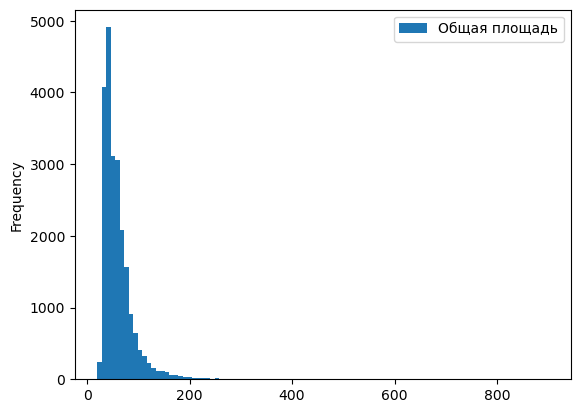

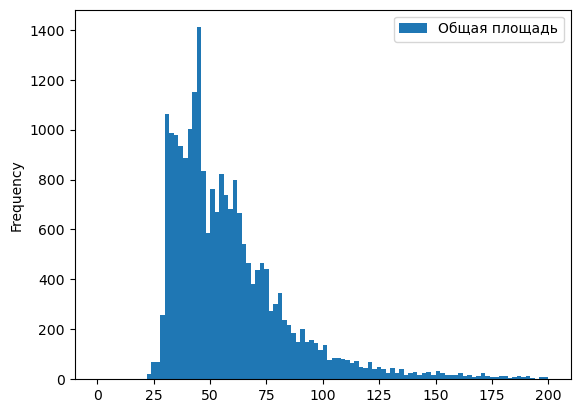

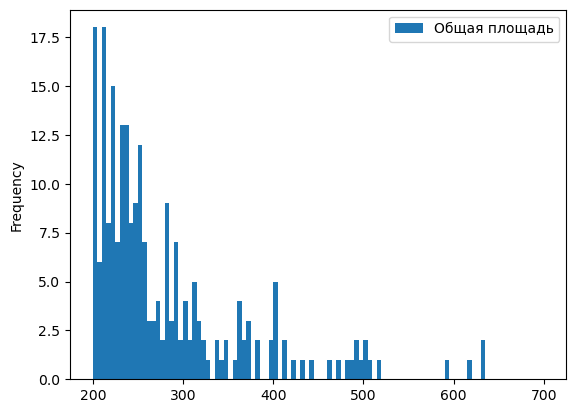

In [71]:
data.plot(kind='hist', y='total_area', bins=100, label='Общая площадь')

data.plot(kind='hist', y='total_area', bins=100, range=(0,200), label='Общая площадь')
data.plot(kind='hist', y='total_area', bins=100, range=(200,700), label='Общая площадь')


Наблюдения по гистограмме:
* квартиры, имееющие общую площадь около 40 $м^2$, продают больше остальных
* основная масса квартир имеет общую площадь от 30 $м^2$ до 70 $м^2$

Жилая площадь: <a id='analysis_LA'></a>

<AxesSubplot:ylabel='Frequency'>

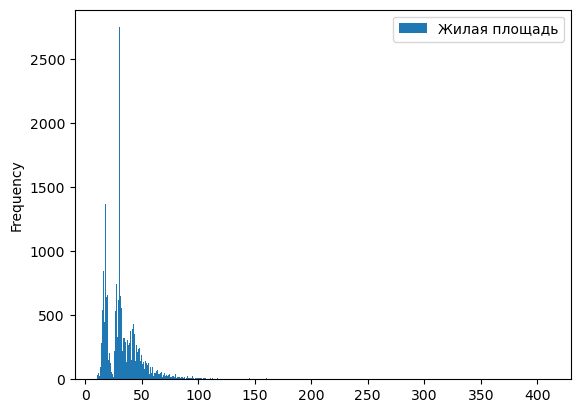

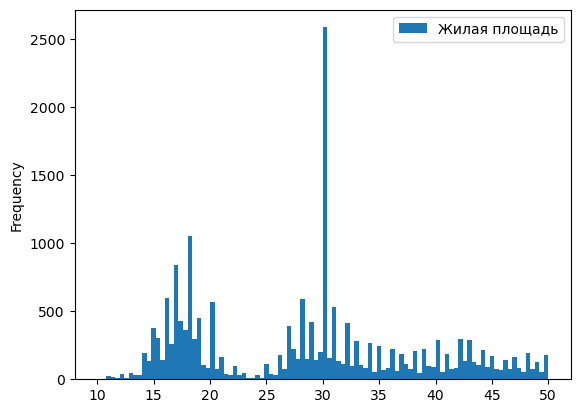

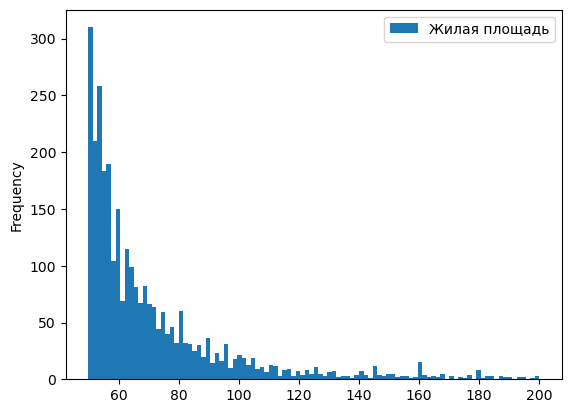

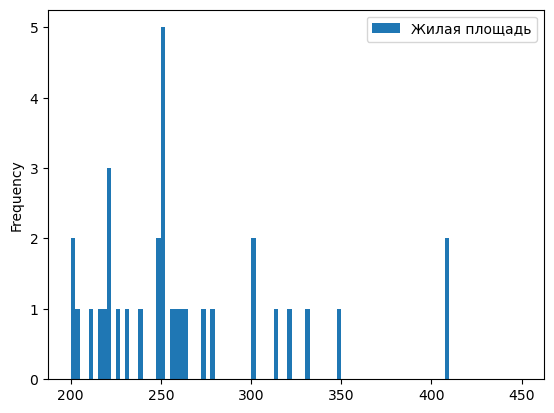

In [72]:
data.plot(kind='hist', y='living_area', bins=500, label='Жилая площадь')

data.plot(kind='hist', y='living_area', bins=100, range=(10,50), label='Жилая площадь')
data.plot(kind='hist', y='living_area', bins=100, range=(50,200), label='Жилая площадь')
data.plot(kind='hist', y='living_area', bins=100, range=(200,450), label='Жилая площадь')

Наблюдения по гистограмме:
* квартиры, имееющие жилую площадь около 30 $м^2$, продают больше остальных
* основная масса квартир имеет  жилую площадь от 15 $м^2$ до 50 $м^2$

Площадь кухни: <a id='analysis_KA'></a>

<AxesSubplot:ylabel='Frequency'>

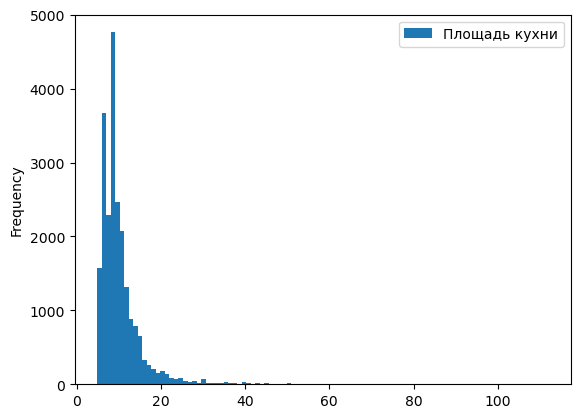

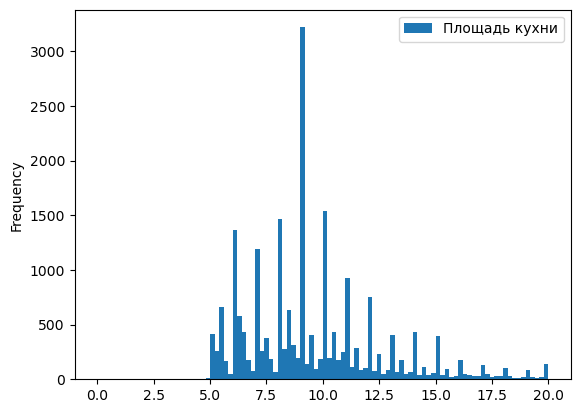

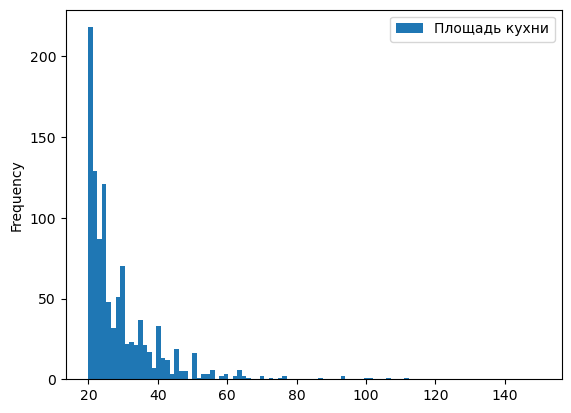

In [73]:
data.plot(kind='hist', y='kitchen_area', bins=100, label='Площадь кухни')

data.plot(kind='hist', y='kitchen_area', bins=100, range=(0,20), label='Площадь кухни')
data.plot(kind='hist', y='kitchen_area', bins=100, range=(20,150), label='Площадь кухни')


Наблюдения по гистограмме:
* квартиры, имееющие площадь кухни около 9 $м^2$, продают больше остальных
* основная масса квартир имеет площадь кухни от 6 $м^2$ до 25 $м^2$

Цена объекта: <a id='analysis_LP'></a>

<AxesSubplot:ylabel='Frequency'>

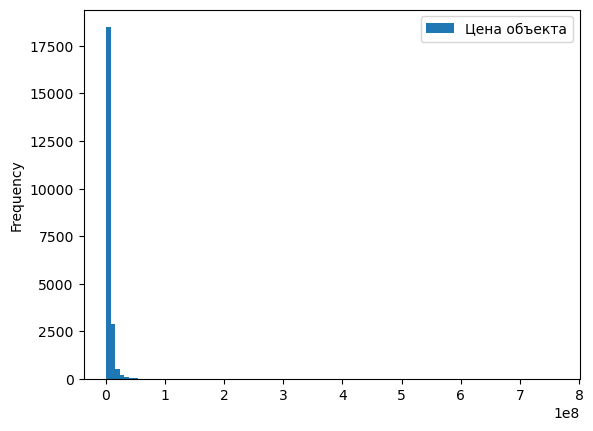

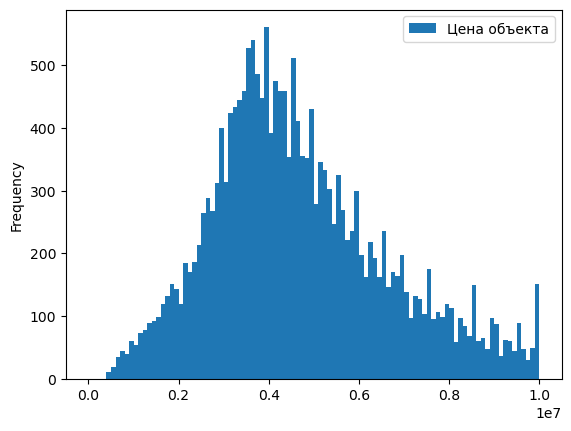

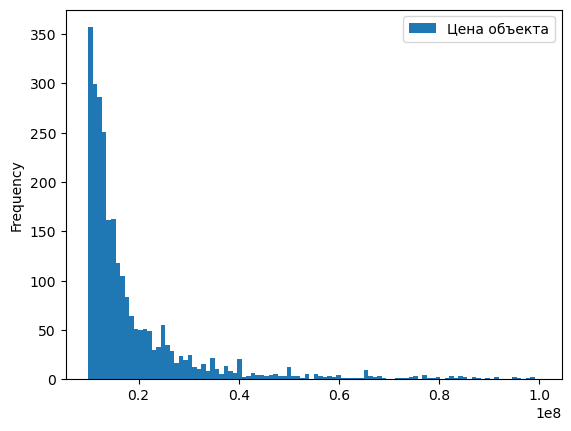

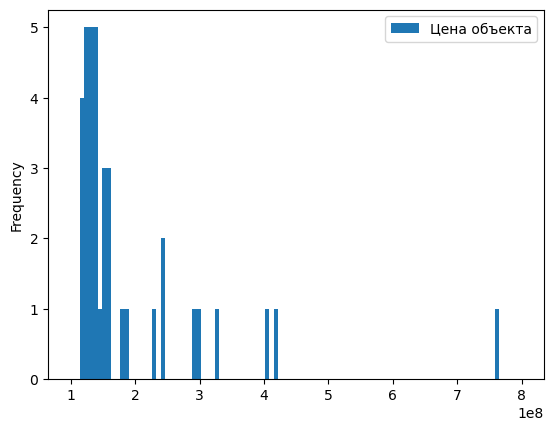

In [74]:
data.plot(kind='hist', y='last_price', bins=100, label='Цена объекта')

data.plot(kind='hist', y='last_price', bins=100, range=(0,10000000), label='Цена объекта')
data.plot(kind='hist', y='last_price', bins=100, range=(10000000,100000000), label='Цена объекта')
data.plot(kind='hist', y='last_price', bins=100, range=(100000000,800000000), label='Цена объекта')


Наблюдения по гистограмме:
* квартиры, имееющие цену около 4 000 00 р., продают больше остальных
* основная масса квартир имеют цену от 2 000 000 р. до 7 000 000 р.

Количество комнат: <a id='analysis_R'></a>

<AxesSubplot:ylabel='Frequency'>

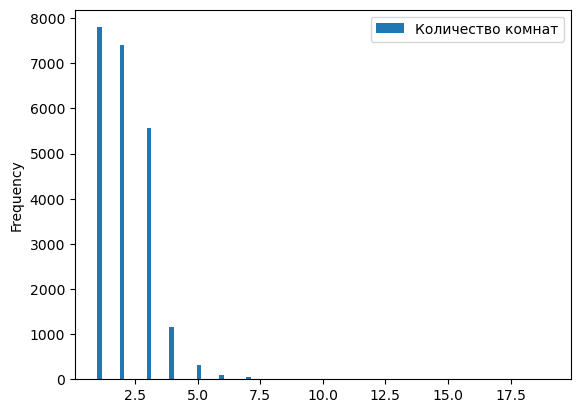

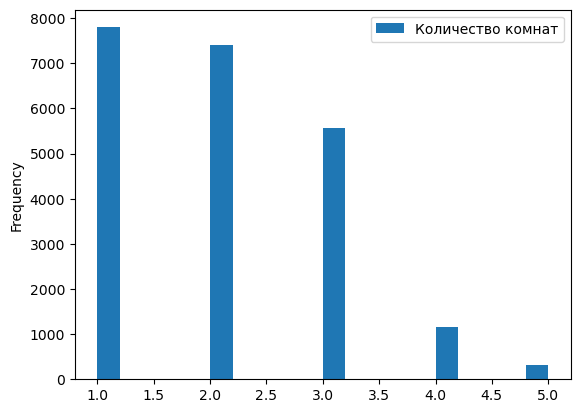

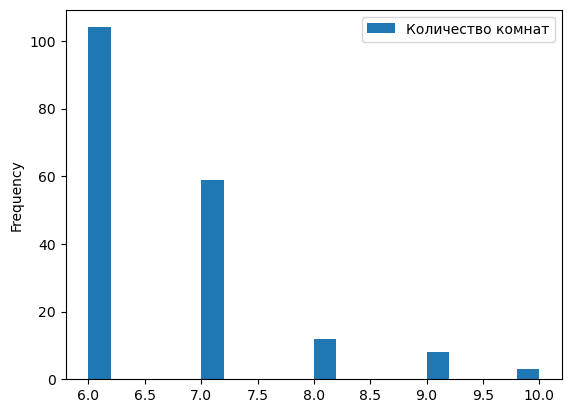

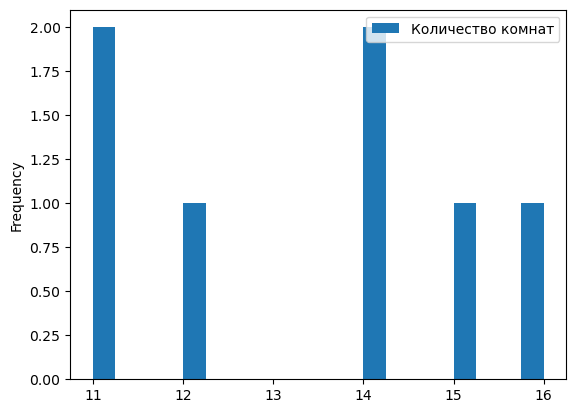

In [75]:
data.plot(kind='hist', y='rooms', bins=100, label='Количество комнат')

data.plot(kind='hist', y='rooms', bins=20, range=(1,5), label='Количество комнат')
data.plot(kind='hist', y='rooms', bins=20, range=(6,10), label='Количество комнат')
data.plot(kind='hist', y='rooms', bins=20, range=(11,16), label='Количество комнат')

Высота потолков: <a id='analysis_CH'></a>

<AxesSubplot:ylabel='Frequency'>

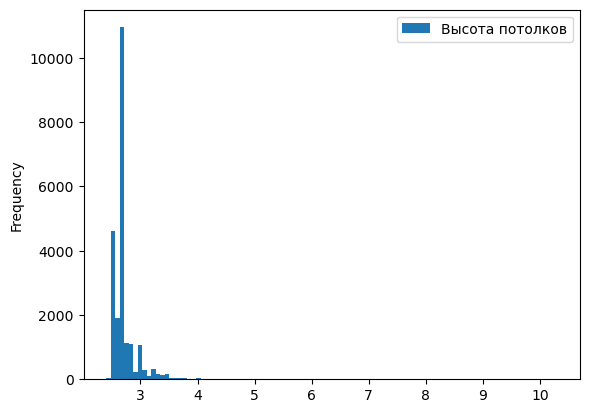

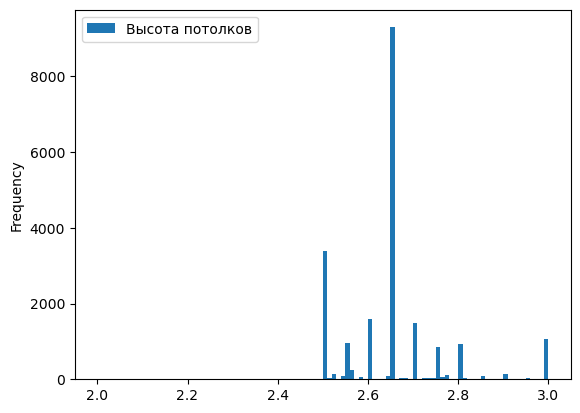

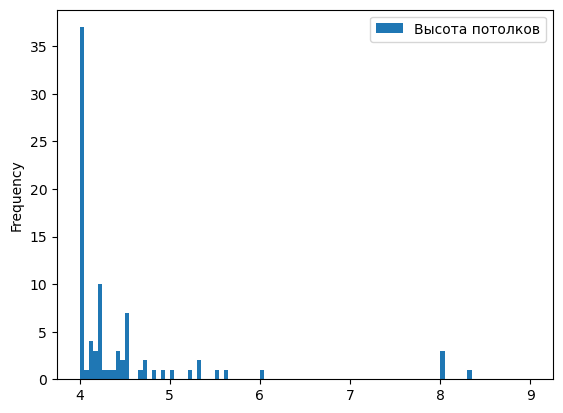

In [76]:
data.plot(kind='hist', y='ceiling_height', bins=100, label='Высота потолков')

data.plot(kind='hist', y='ceiling_height', bins=100, range=(2,3), label='Высота потолков')
data.plot(kind='hist', y='ceiling_height', bins=100, range=(4,9), label='Высота потолков')


Наблюдения по гистограмме:
* квартиры, имееющие высоту потолков 2,7 м, продают больше остальных
* основная масса квартир имеет высоту от 2,5 м. до 3 м.

Этаж квартиры: <a id='analysis_F'></a>

<AxesSubplot:ylabel='Frequency'>

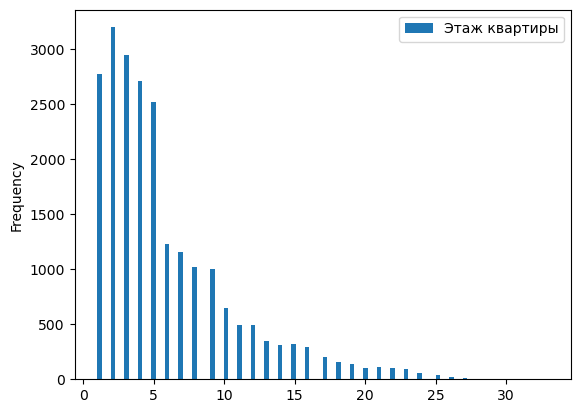

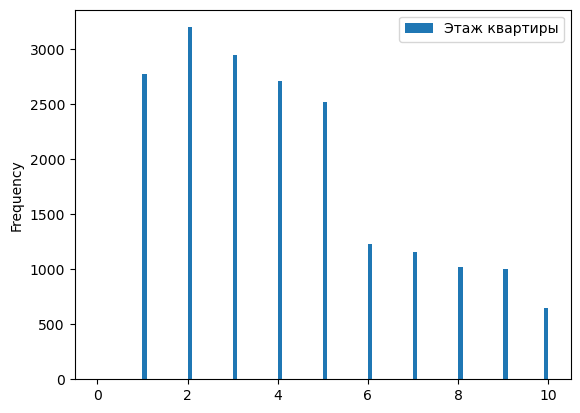

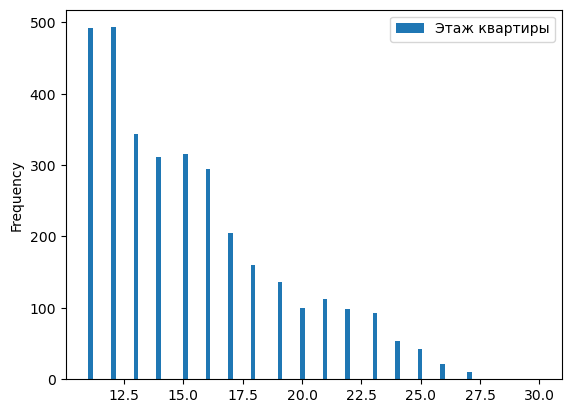

In [77]:
data.plot(kind='hist', y='floor', bins=100, label='Этаж квартиры')

data.plot(kind='hist', y='floor', bins=100, range=(0,10), label='Этаж квартиры')
data.plot(kind='hist', y='floor', bins=100, range=(11,30), label='Этаж квартиры')


Наблюдения по гистограмме:
* квартиры на втором этаже продают больше остальных
* основная масса квартир расположена с первого по девятый этажи

Тип этажа квартиры («первый», «последний», «другой»): <a id='analysis_FT'></a>

<AxesSubplot:>

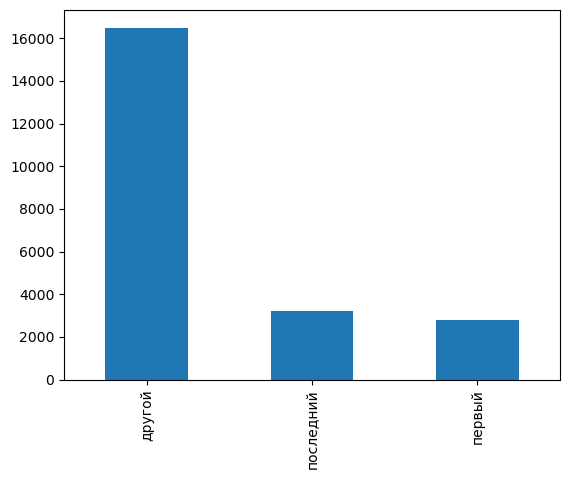

In [78]:
data['floor_type'].value_counts().plot.bar()

Наблюдения по гистограмме:
* подавляющее большинство квартир находятся не на первом и не на последнем этажах
* первых и последних этажей примерно равное количество

Общее количество этажей в доме: <a id='analysis_FTot'></a>

<AxesSubplot:ylabel='Frequency'>

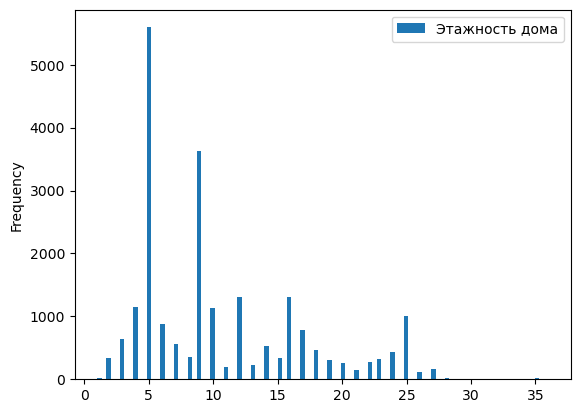

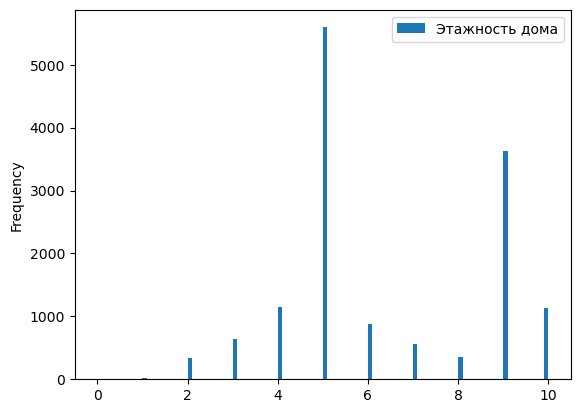

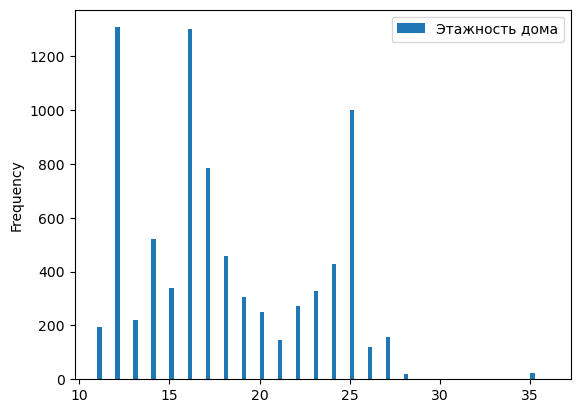

In [79]:
data.plot(kind='hist', y='floors_total', bins=100, label='Этажность дома')

data.plot(kind='hist', y='floors_total', bins=100, range=(0,10), label='Этажность дома')
data.plot(kind='hist', y='floors_total', bins=100, range=(11,36), label='Этажность дома')


Наблюдения по гистограмме:
* наиболее распространены 5 и 9 этажные дома
* чуть менее распространены 12, 16 и 25 этажные дома

Расстояние до центра города в метрах: <a id='analysis_CCN'></a>

<AxesSubplot:ylabel='Frequency'>

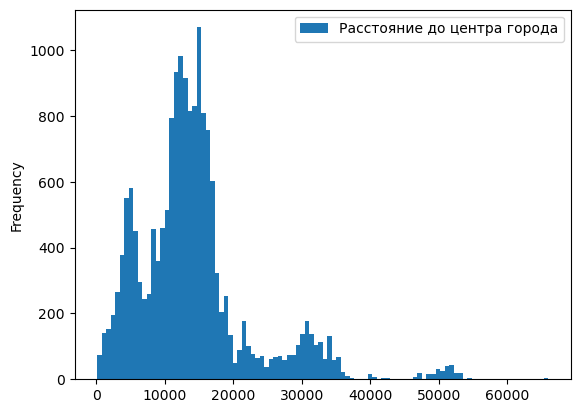

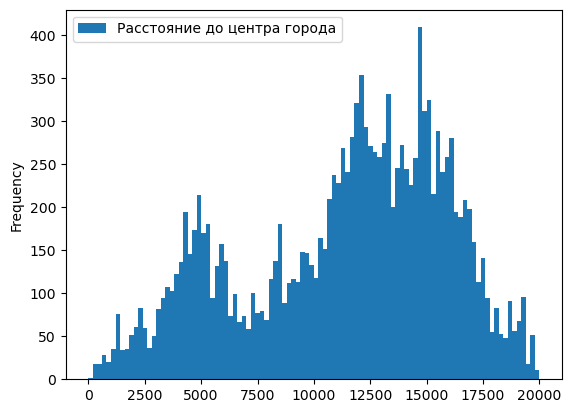

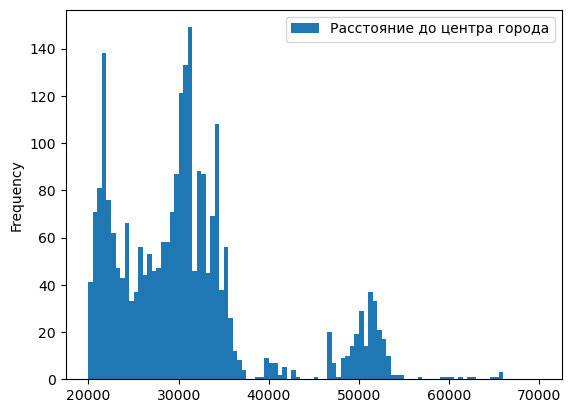

In [80]:
data.plot(kind='hist', y='cityCenters_nearest', bins=100, label='Расстояние до центра города')

data.plot(kind='hist', y='cityCenters_nearest', bins=100, range=(0,20000), label='Расстояние до центра города')
data.plot(kind='hist', y='cityCenters_nearest', bins=100, range=(20000,70000), label='Расстояние до центра города')


Наблюдения по гистограмме:
* основная масса квартир находится в пределах от 10 км до 17 км от центра города.

Расстояние до ближайшего аэропорта: <a id='analysis_AN'></a>

<AxesSubplot:ylabel='Frequency'>

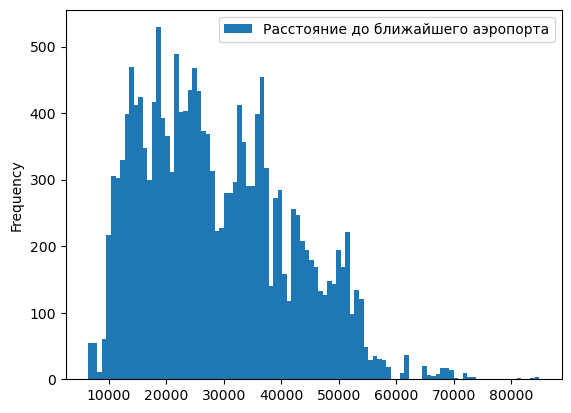

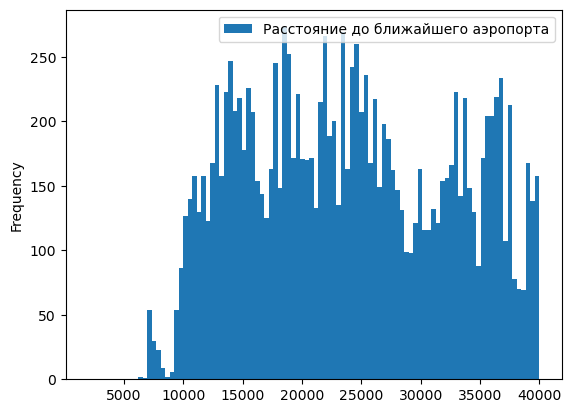

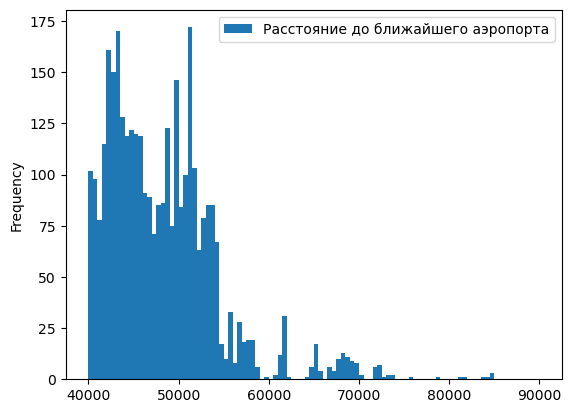

In [81]:
data.plot(kind='hist', y='airports_nearest', bins=100, label='Расстояние до ближайшего аэропорта')

data.plot(kind='hist', y='airports_nearest', bins=100, range=(2000,40000), label='Расстояние до ближайшего аэропорта')
data.plot(kind='hist', y='airports_nearest', bins=100, range=(40000,90000), label='Расстояние до ближайшего аэропорта')


Наблюдения по гистограмме:
* основная масса квартир находится в пределах от 10 км до 55 км от ближайшего аэропорта.

Расстояние до ближайшего парка: <a id='analysis_PN'></a>

<AxesSubplot:ylabel='Frequency'>

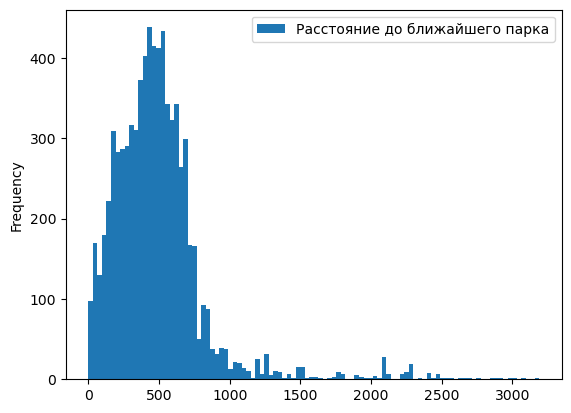

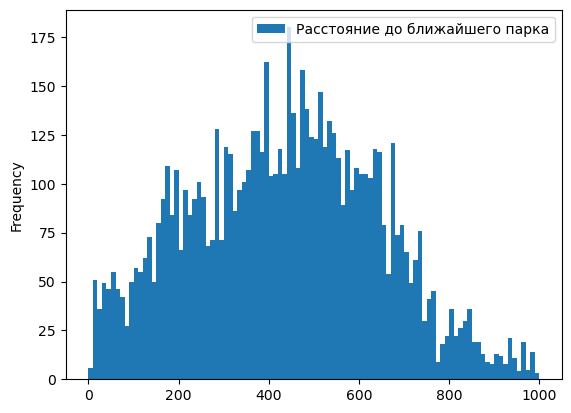

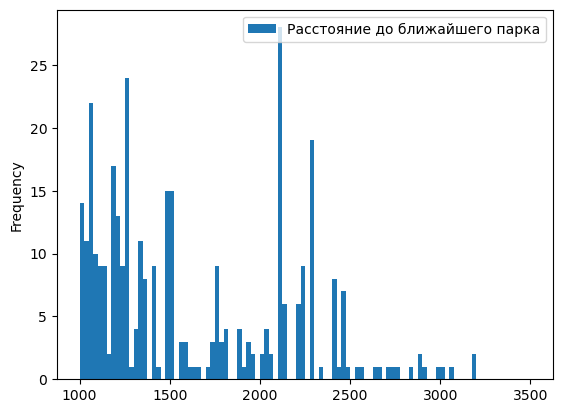

In [82]:
data.plot(kind='hist', y='parks_nearest', bins=100, label='Расстояние до ближайшего парка')

data.plot(kind='hist', y='parks_nearest', bins=100, range=(0,1000), label='Расстояние до ближайшего парка')
data.plot(kind='hist', y='parks_nearest', bins=100, range=(1000,3500), label='Расстояние до ближайшего парка')


Наблюдения по гистограмме:
* у основной части квартир парковая доступность в пределах 800 м

День публикации объявления: <a id='analysis_DP'></a>

<AxesSubplot:ylabel='Frequency'>

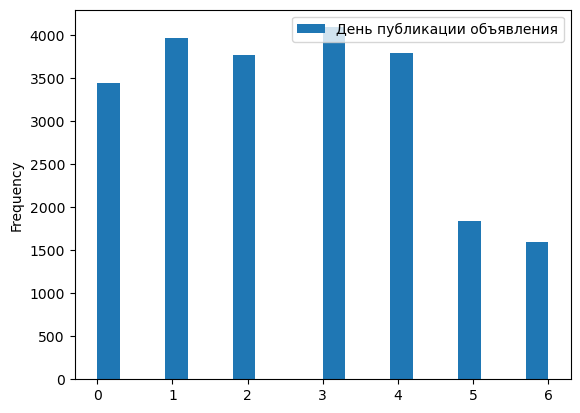

In [83]:
data.plot(kind='hist', y='day_publication', bins=20, label='День публикации объявления')

Наблюдения по гистограмме:
* основная активность в будние дни
* в выходные активность публикации примерно в два раза меньше

Месяц публикации объявления: <a id='analysis_MP'></a>

<AxesSubplot:ylabel='Frequency'>

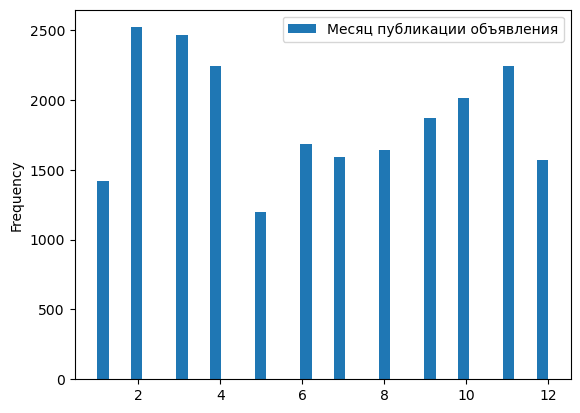

In [84]:
data.plot(kind='hist', y='month_publication', bins=40, label='Месяц публикации объявления')

Наблюдения по гистограмме:
* основная активность — февраль, март, апрель и ноябрь
* минимальная активность в январе, мае и декабре, что, вероятно, связано с праздничными днями в этих месяцах 

Изучим, как быстро продавались квартиры: <a id='analysis_Speed_sale'></a>

count    19455.000000
mean       182.258443
std        221.289929
min          1.000000
25%         45.000000
50%         96.000000
75%        233.000000
max       1580.000000
Name: days_exposition, dtype: float64

Количество дней с самым большим числом продаж:
 45.0    836
Name: days_exposition, dtype: int64


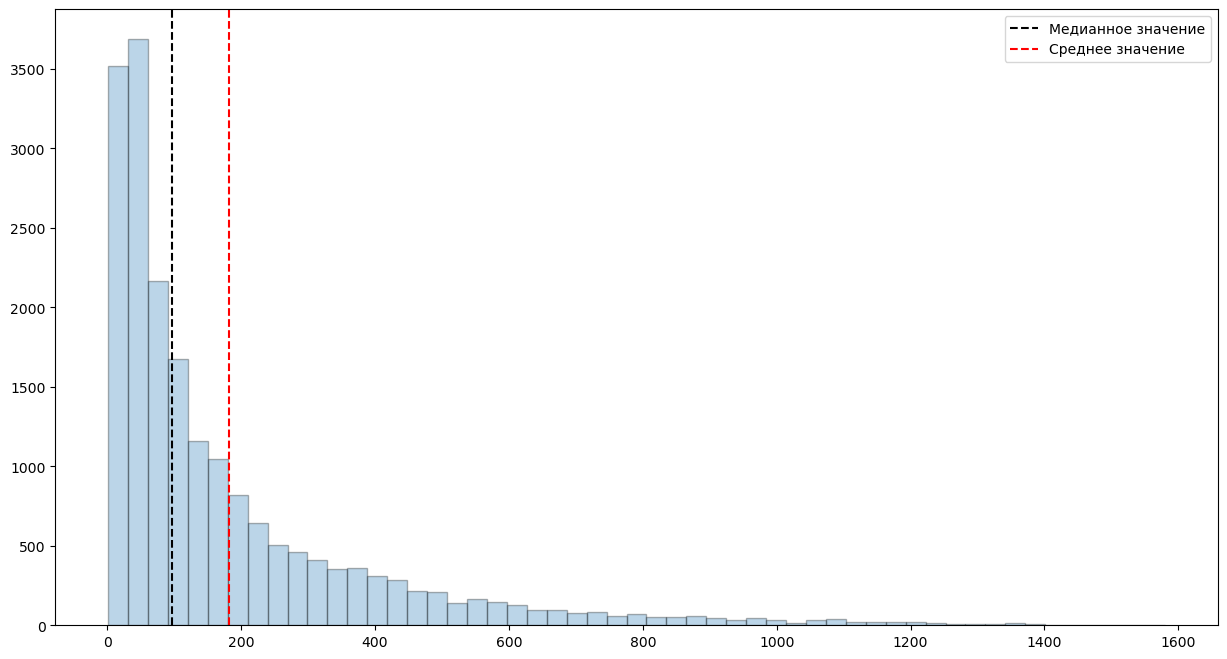

In [85]:
display(data['days_exposition'].describe())
print('Количество дней с самым большим числом продаж:\n', data['days_exposition'].value_counts().head(1))

bins=round(data['days_exposition'].max()/30) #найдем оптимальное количество корзин для отображения по месяцам

fig, ax = plt.subplots(figsize = (15, 8))
ax.hist(data['days_exposition'], bins=bins, edgecolor="black", alpha=0.3)

# axvline: axis vertical line
ax.axvline(data['days_exposition'].median(), color="black", ls="--", label="Медианное значение")
ax.axvline(data['days_exposition'].mean(), color="red", ls="--", label="Среднее значение")
ax.legend();

* Медианное значение — 96 дней
* Среднее значение — 182 дня
* Половина квартир продается в течении 96 дней
* Самый высокий показатель — 45 дней, быстрыми продажами можно считать те, которые продавались меньше 45 дней
* Долгими продажами можно считать те, которые продавались больше 96 дней
* Самая долгая продажа — 1580 дней

Изучим, какие факторы больше всего влияют на общую (полную) стоимость объекта:

Зависимость цены от общей площади: <a id='analysis_price_TA'></a>

Коэффициент корреляции Пирсона: 0.65


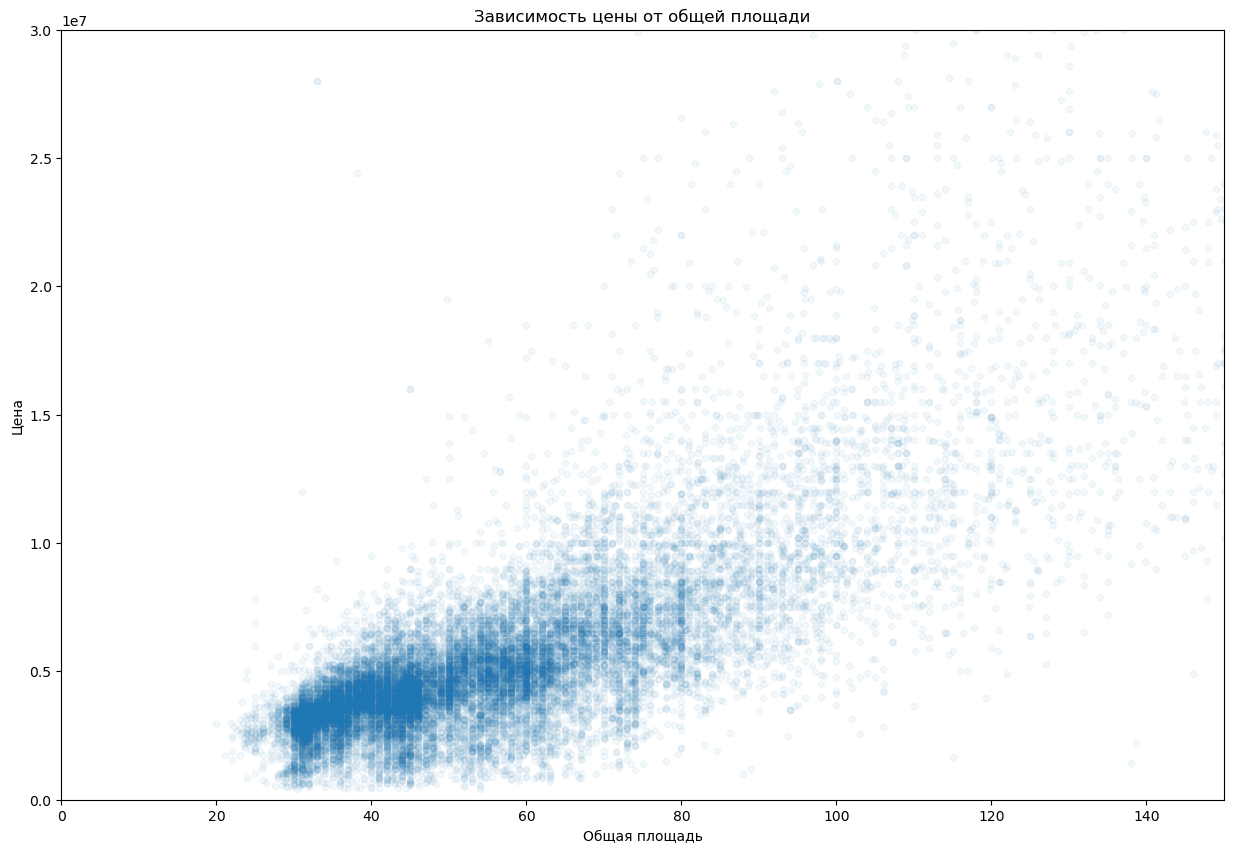

In [86]:
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.05, figsize=(15,10))
plt.xlim([0, 150])
plt.ylim([0, 0.3e8])
plt.xlabel('Общая площадь')
plt.ylabel('Цена')
plt.title('Зависимость цены от общей площади')
print(f"Коэффициент корреляции Пирсона: {data['last_price'].corr(data['total_area']) :.2f}")

Судя по диаграмме рассеяния и коэффициенту корреляции цена и общая площадь имеют линейную связь. При увеличении площади растет и цена

Зависимость цены от жилой площади: <a id='analysis_price_LA'></a>

Коэффициент корреляции Пирсона: 0.54


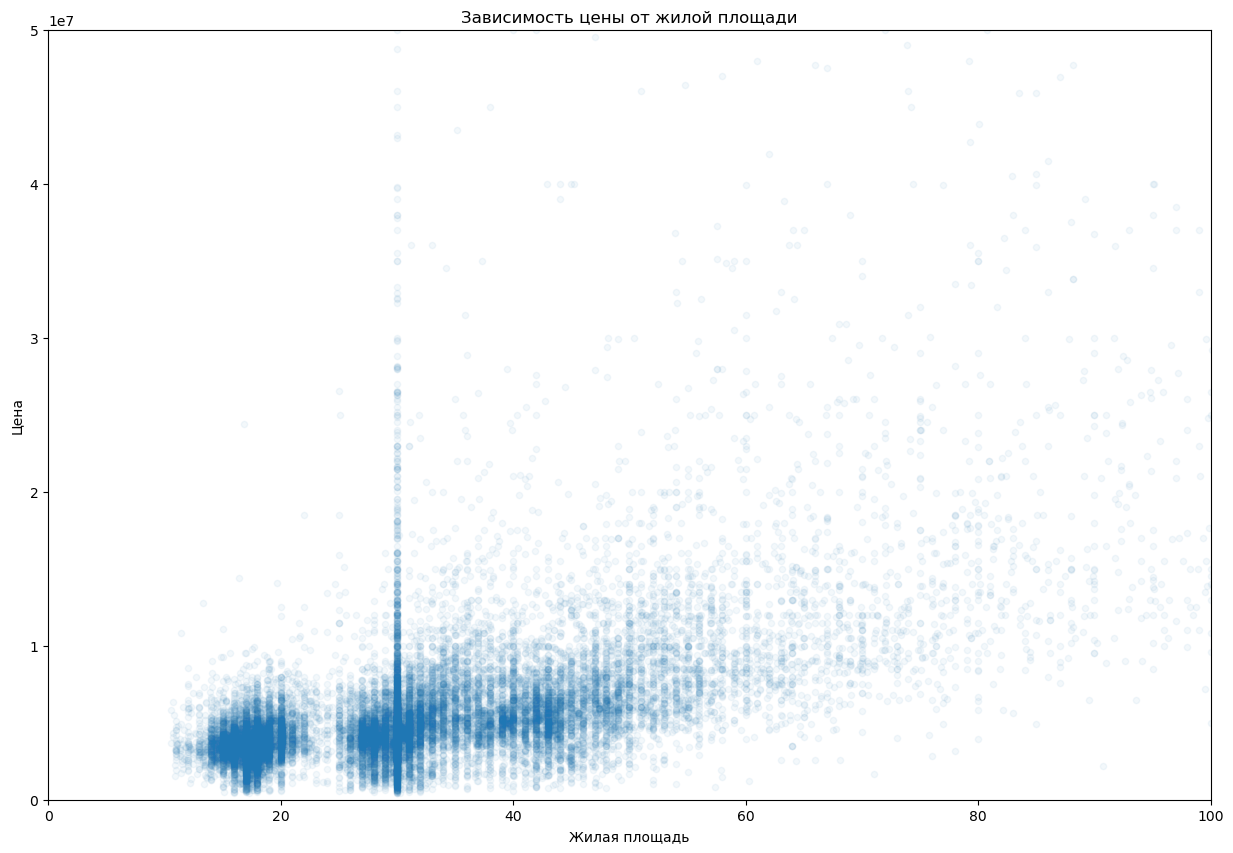

In [87]:
data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.05, figsize=(15,10))
plt.xlim([0, 100])
plt.ylim([0, 0.5e8])
plt.xlabel('Жилая площадь')
plt.ylabel('Цена')
plt.title('Зависимость цены от жилой площади')
print(f"Коэффициент корреляции Пирсона: {data['last_price'].corr(data['living_area']) :.2f}")

Судя по диаграмме рассеяния и коэффициенту корреляции цена и жилая площадь имеют линейную связь. При увеличении площади растет и цена

Зависимость цены от площади кухни: <a id='analysis_price_KA'></a>

Коэффициент корреляции Пирсона: 0.45


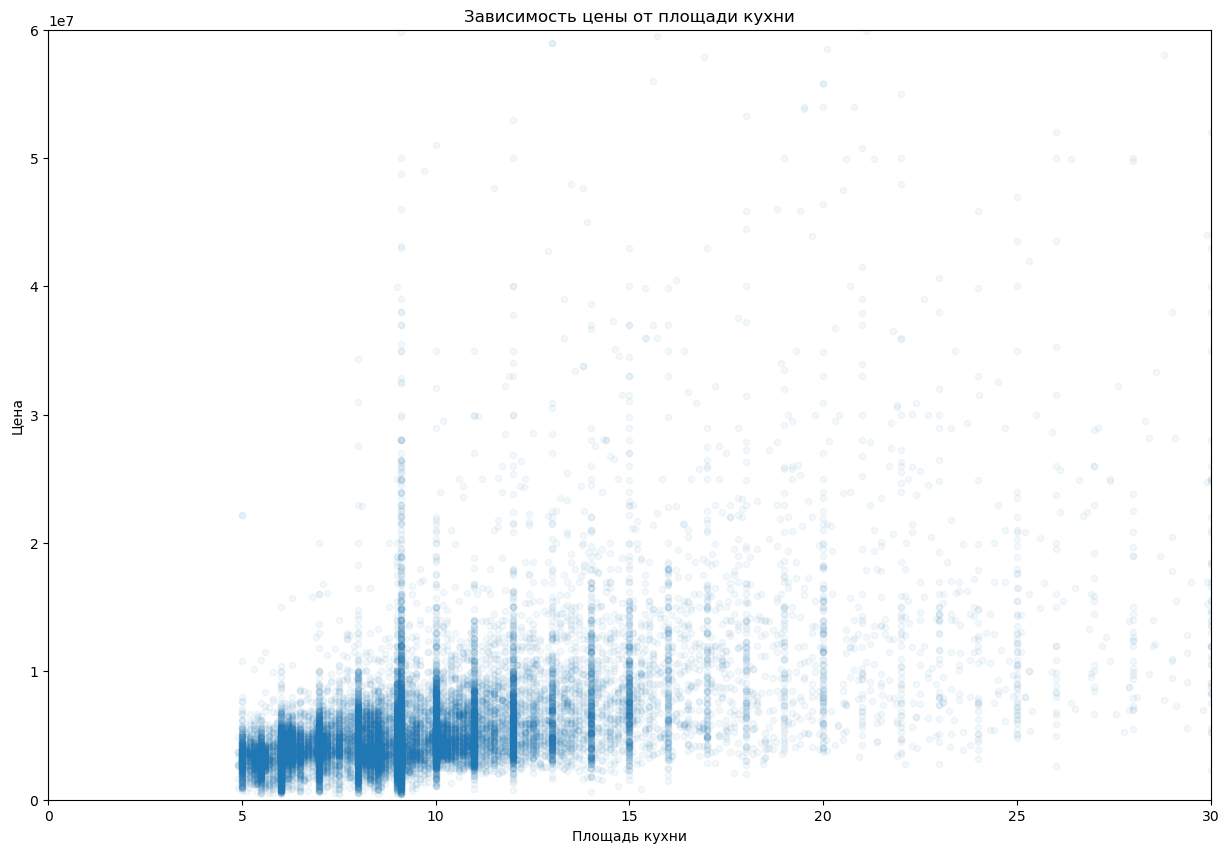

In [88]:
data.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.05, figsize=(15,10))
plt.xlim([0, 30])
plt.ylim([0, 0.6e8])
plt.xlabel('Площадь кухни')
plt.ylabel('Цена')
plt.title('Зависимость цены от площади кухни')
print(f"Коэффициент корреляции Пирсона: {data['last_price'].corr(data['kitchen_area']) :.2f}")

Судя по диаграмме рассеяния и коэффициенту корреляции цена и площадь кухни имеют линейную связь, но менее выраженную, чем с общей и жилой площадью. При увеличении площади растет и цена

Зависимость цены от количества комнат: <a id='analysis_price_R'></a>

Коэффициент корреляции Пирсона: 0.37


<AxesSubplot:title={'center':'Зависимость максимальной цены \n от количества комнат'}, xlabel='Количество комнат'>

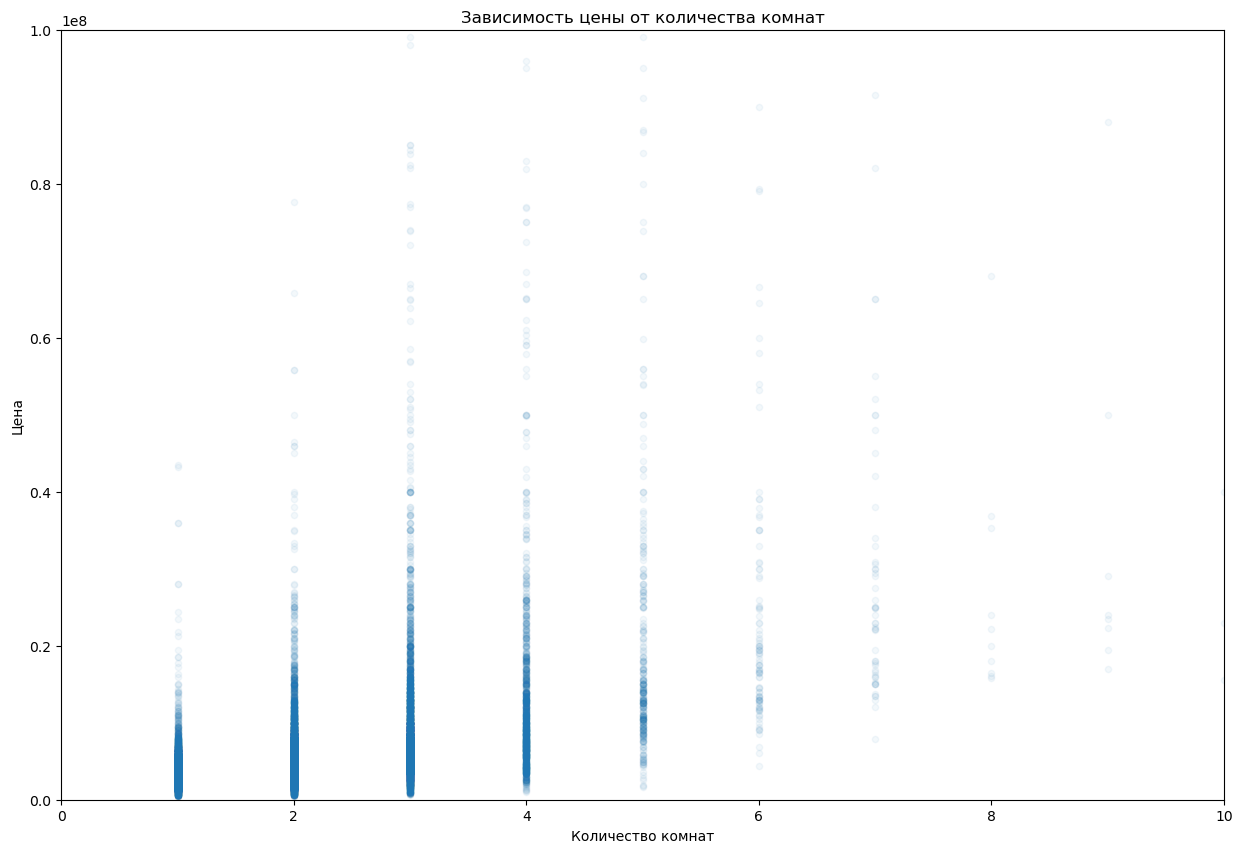

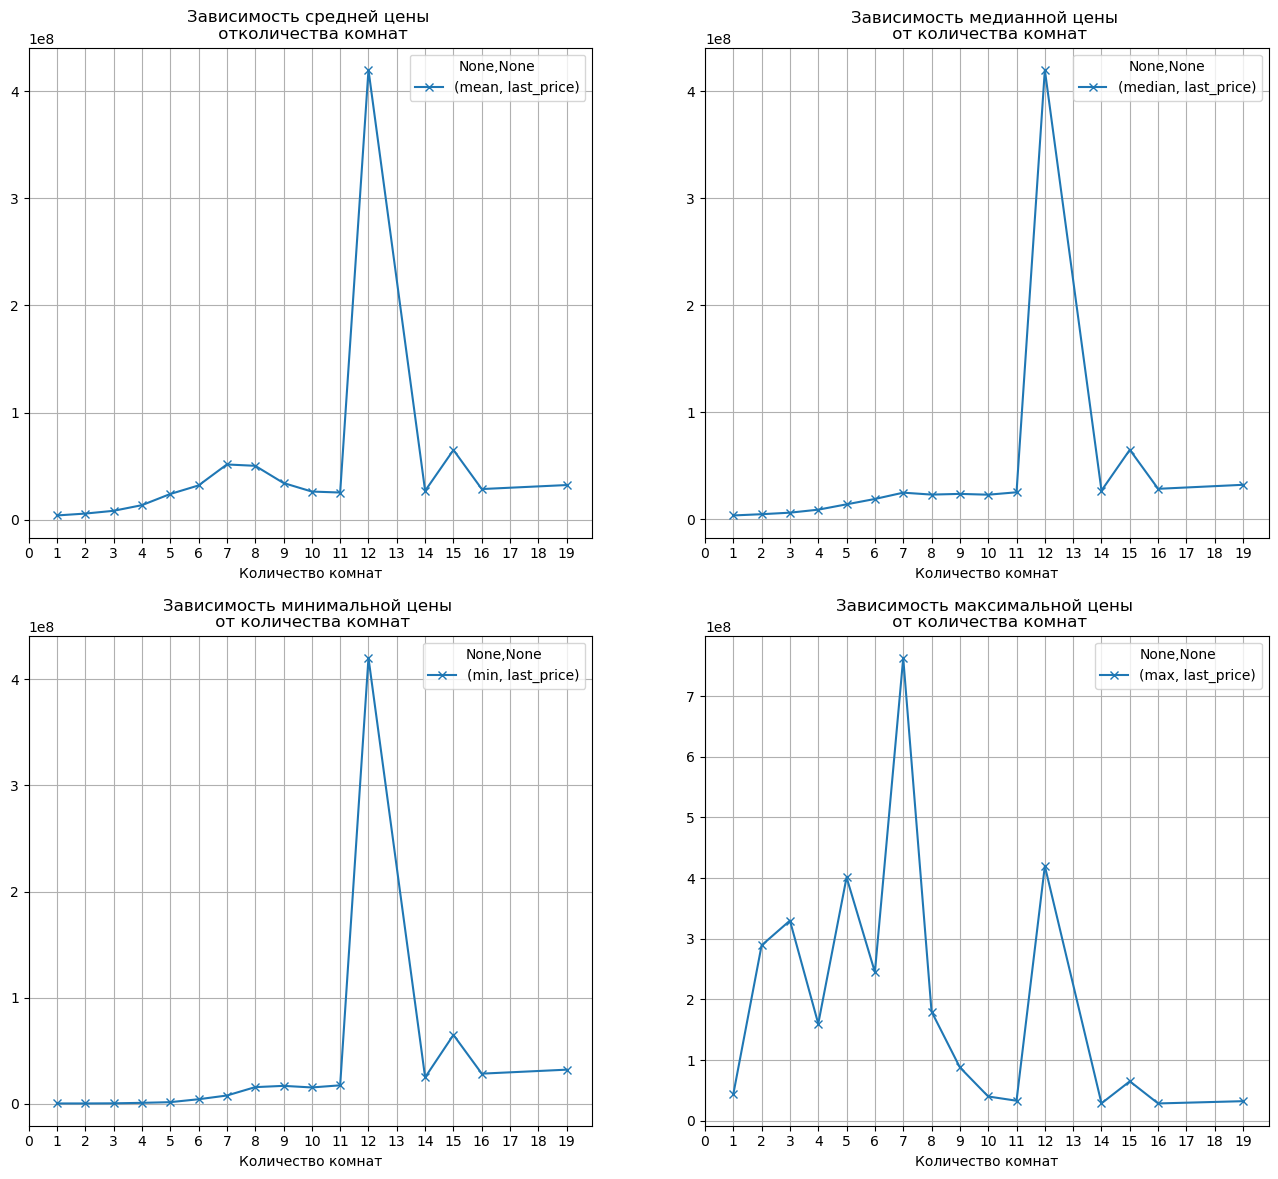

In [89]:
data.plot(x='rooms', y='last_price', kind='scatter', alpha=0.05, figsize=(15,10))
plt.xlim([0, 10])
plt.ylim([0, 1e8])
plt.xlabel('Количество комнат')
plt.ylabel('Цена')
plt.title('Зависимость цены от количества комнат')
print(f"Коэффициент корреляции Пирсона: {data['last_price'].corr(data['rooms']) :.2f}")

fig, ax = plt.subplots(2,2,figsize=(16, 14))

data.pivot_table(index='rooms', values='last_price', aggfunc=['mean']).plot(
    title='Зависимость средней цены \n отколичества комнат', style='x-', grid=True, xlabel='Количество комнат', 
    xticks=([w*1 for w in range(20)]), ax=ax[0,0])

data.pivot_table(index='rooms', values='last_price', aggfunc=['median']).plot(
    title='Зависимость медианной цены \n от количества комнат', style='x-', grid=True, xlabel='Количество комнат', 
    xticks=([w*1 for w in range(20)]), ax=ax[0,1])

data.pivot_table(index='rooms', values='last_price', aggfunc=['min']).plot(
    title='Зависимость минимальной цены \n от количества комнат', style='x-', grid=True, xlabel='Количество комнат', 
    xticks=([w*1 for w in range(20)]), ax=ax[1,0])

data.pivot_table(index='rooms', values='last_price', aggfunc=['max']).plot(
    title='Зависимость максимальной цены \n от количества комнат', style='x-', grid=True, xlabel='Количество комнат', 
    xticks=([w*1 for w in range(20)]), ax=ax[1,1])

Судя по диаграмме рассеяния и коэффициенту корреляции цена и количество комнат имеют слабую линейную связь. При увеличении количества комнат растет и цена

Зависимость цены от этажа, на котором расположена квартира (первый, последний, другой): <a id='analysis_price_FT'></a>

<AxesSubplot:title={'center':'Зависимость максимальной цены \n от этажа, на котором расположена квартира'}, xlabel='Этаж'>

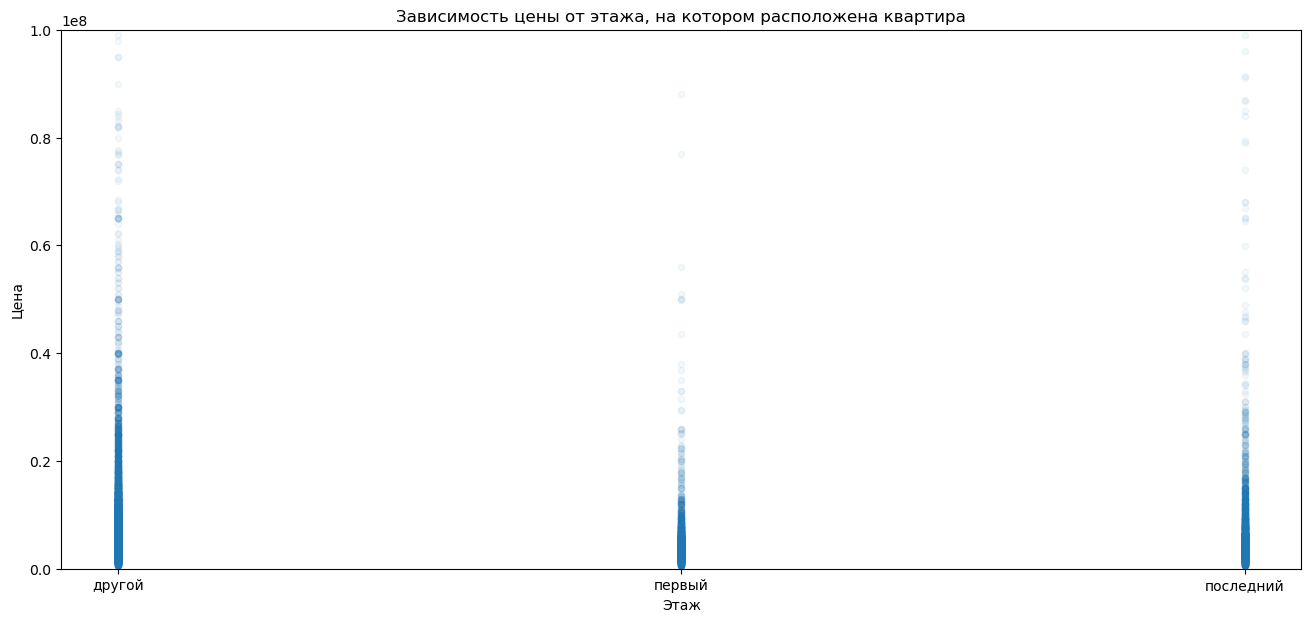

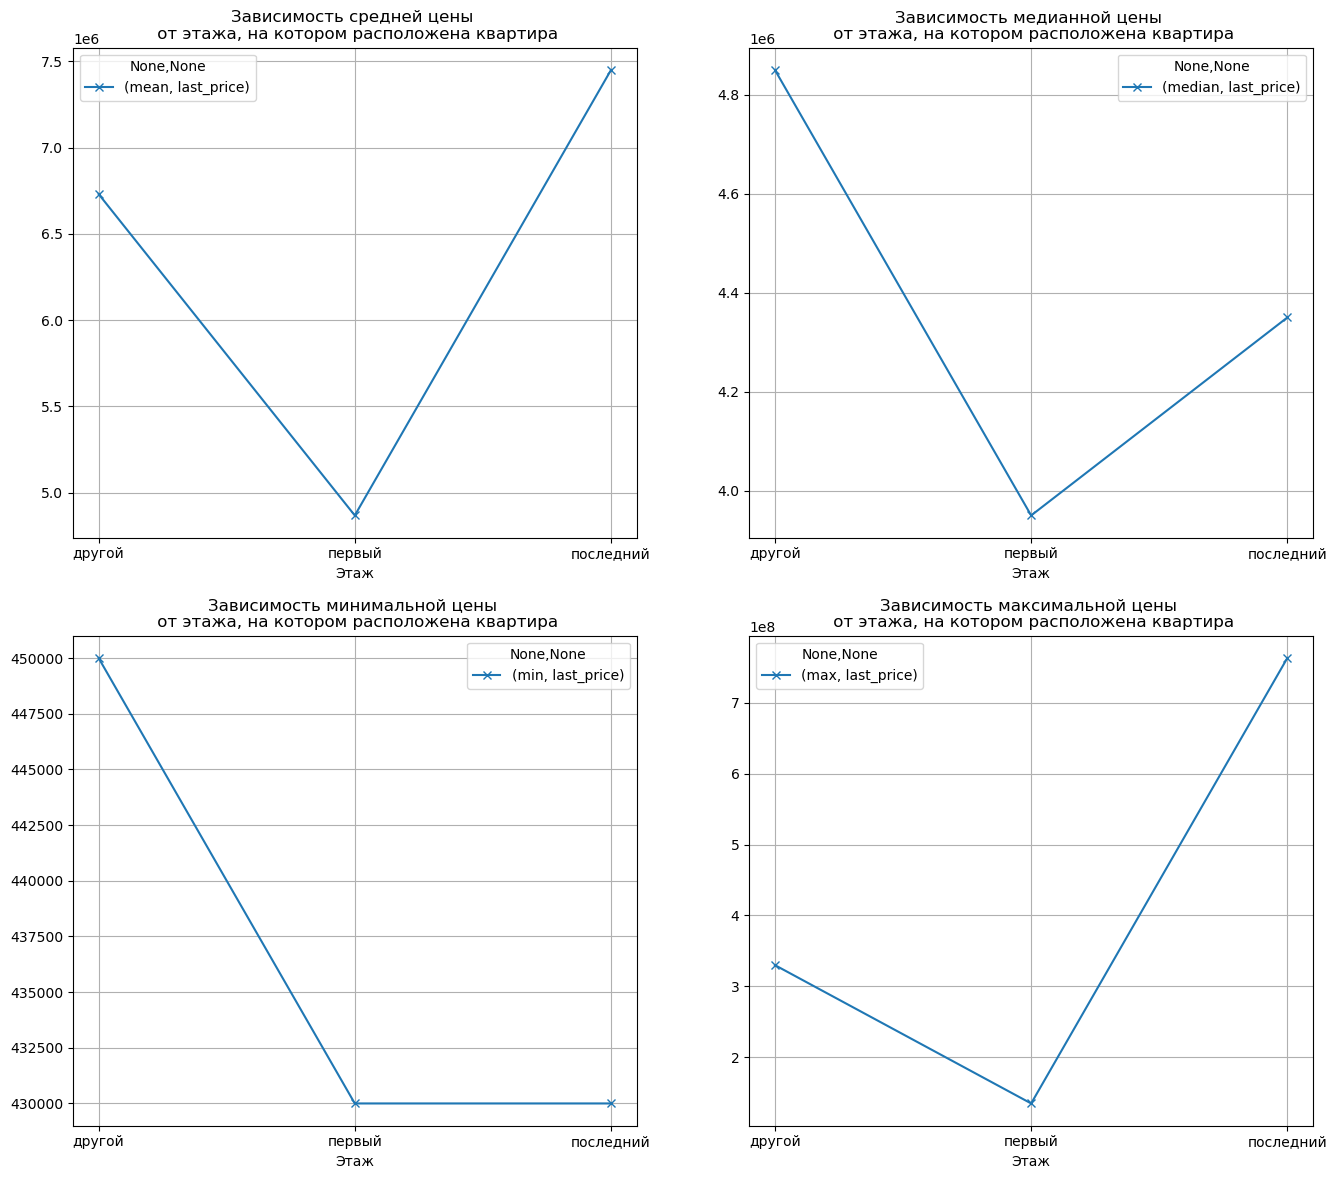

In [90]:
data.plot(x='floor_type', y='last_price', kind='scatter', alpha=0.05, figsize=(16,7))
plt.ylim([0, 1e8])
plt.xlabel('Этаж')
plt.ylabel('Цена')
plt.title('Зависимость цены от этажа, на котором расположена квартира')

fig, ax = plt.subplots(2,2,figsize=(16, 14))

data.pivot_table(index='floor_type', values='last_price', aggfunc=['mean']).plot(
    title='Зависимость средней цены \n от этажа, на котором расположена квартира', style='x-', grid=True, 
    xlabel='Этаж', xticks=([w*1 for w in range(3)]), ax=ax[0,0])

data.pivot_table(index='floor_type', values='last_price', aggfunc=['median']).plot(
    title='Зависимость медианной цены \n от этажа, на котором расположена квартира', style='x-', grid=True, 
    xlabel='Этаж', xticks=([w*1 for w in range(3)]), ax=ax[0,1])

data.pivot_table(index='floor_type', values='last_price', aggfunc=['min']).plot(
    title='Зависимость минимальной цены \n от этажа, на котором расположена квартира', style='x-', grid=True, 
    xlabel='Этаж', xticks=([w*1 for w in range(3)]), ax=ax[1,0])

data.pivot_table(index='floor_type', values='last_price', aggfunc=['max']).plot(
    title='Зависимость максимальной цены \n от этажа, на котором расположена квартира', style='x-', grid=True, 
    xlabel='Этаж', xticks=([w*1 for w in range(3)]), ax=ax[1,1])



Судя по диаграмме рассеяния цена и этажность либо имеют слабую взаимосвязь, либо более сложную (не линейную) взаимосвязь. Минимальная цена первого и последнего этажа равны и дешевле всех остальных этажей. Вероятно, это связано с меньшей популярностью таких квартир в старом фонде из-за близости подвала и чердака. Максимальная цена первого этажа меньше, чем остальных этажей. Максимальная цена последнего этажа выше остальных, вероятно, связано с пентхаусами

Зависимость цены от даты размещения (день недели): <a id='analysis_price_DP'></a>

Коэффициент корреляции Пирсона: 0.00


<AxesSubplot:title={'center':'Зависимость максимальной цены \n от дня размещения'}, xlabel='День размещения'>

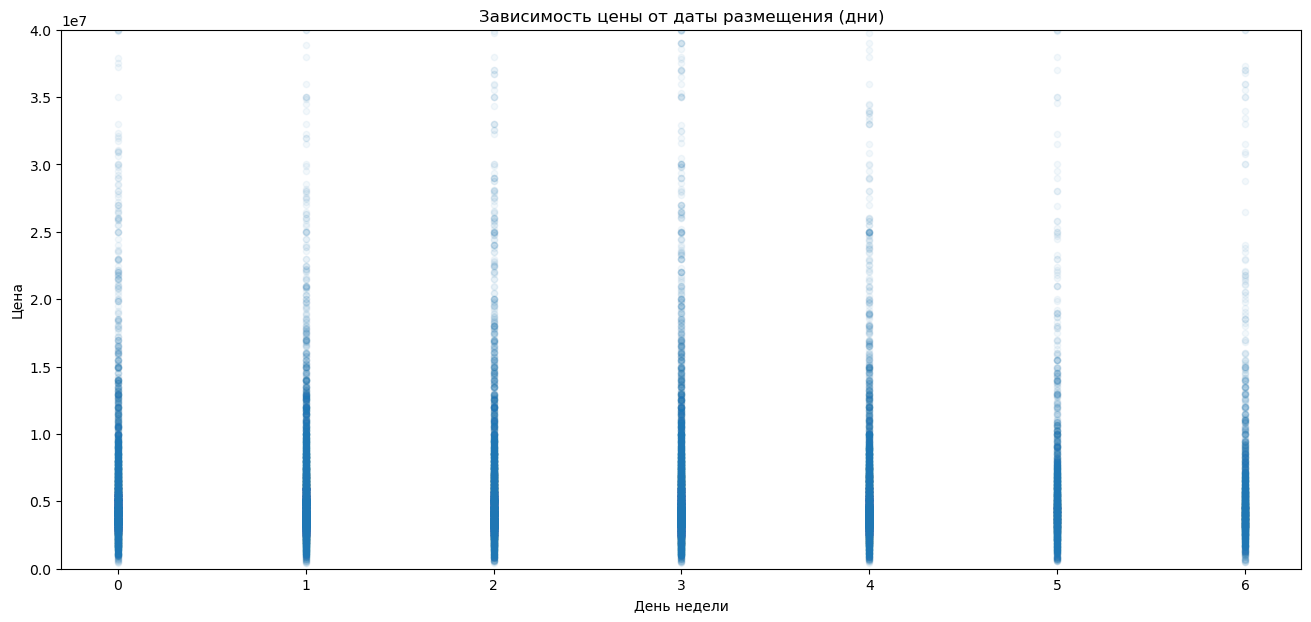

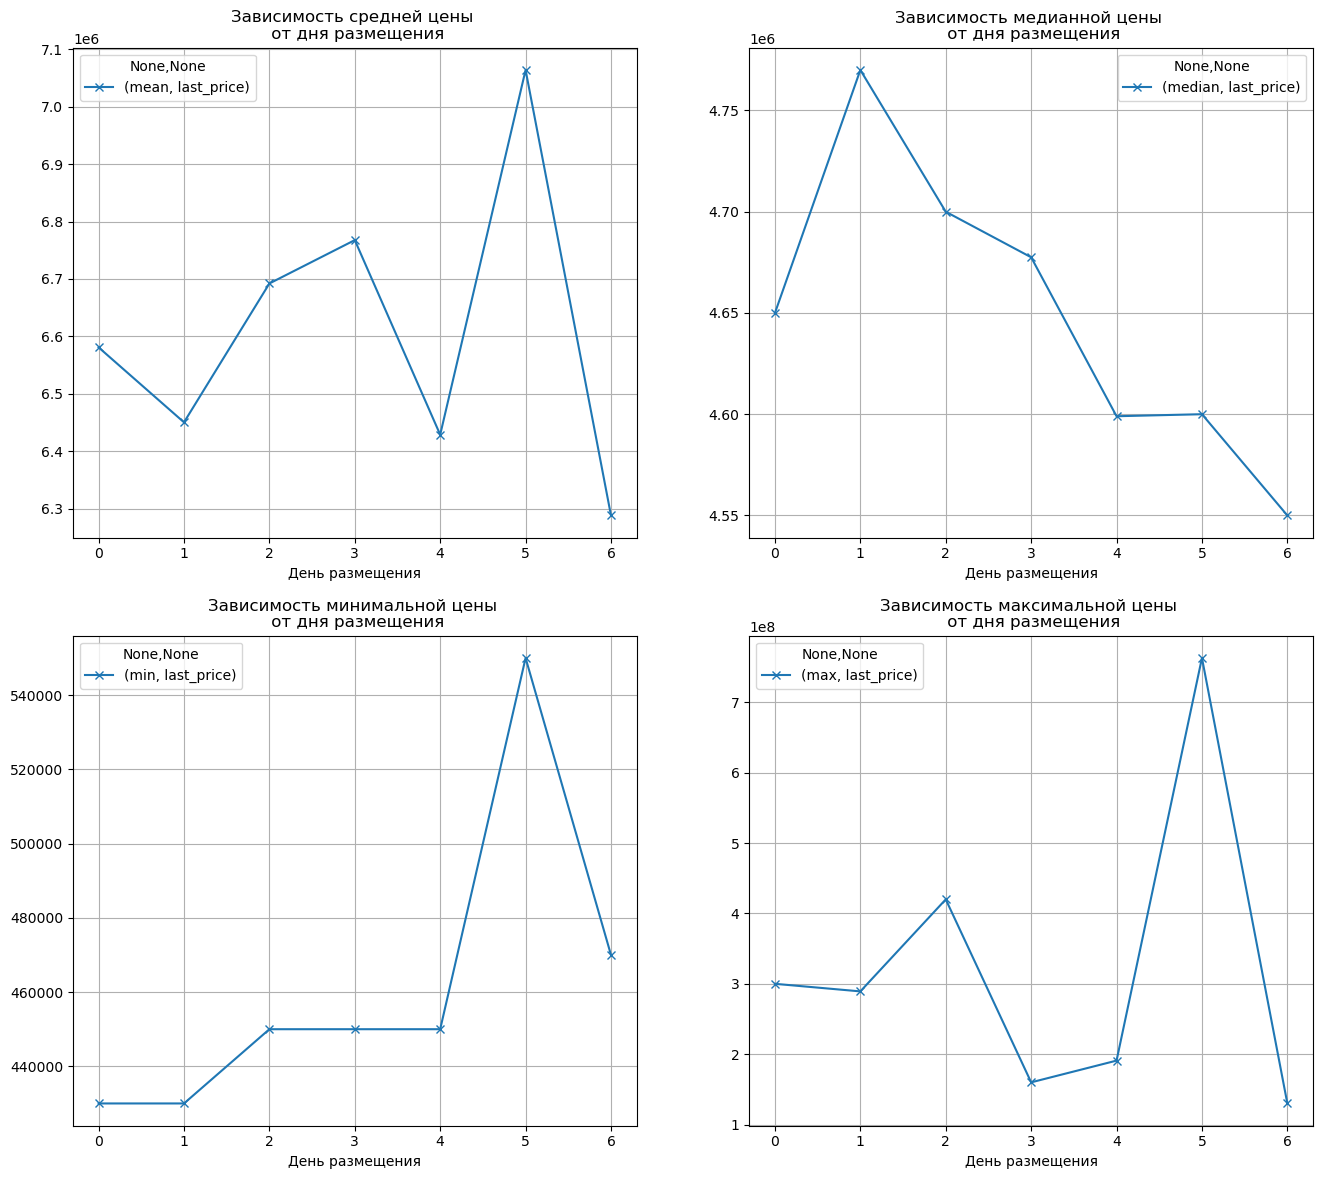

In [91]:
data.plot(x='day_publication', y='last_price', kind='scatter', alpha=0.05, figsize=(16,7))
plt.ylim([0, 4e7])
plt.xlabel('День недели')
plt.ylabel('Цена')
plt.title('Зависимость цены от даты размещения (дни)')
print(f"Коэффициент корреляции Пирсона: {data['last_price'].corr(data['day_publication']) :.2f}")

fig, ax = plt.subplots(2,2,figsize=(16, 14))

data.pivot_table(index='day_publication', values='last_price', aggfunc=['mean']).plot(
    title='Зависимость средней цены \n от дня размещения', style='x-', grid=True, xlabel='День размещения',
    xticks=([w*1 for w in range(7)]), ax=ax[0,0])

data.pivot_table(index='day_publication', values='last_price', aggfunc=['median']).plot(
    title='Зависимость медианной цены \n от дня размещения', style='x-', grid=True, xlabel='День размещения',
    xticks=([w*1 for w in range(7)]), ax=ax[0,1])

data.pivot_table(index='day_publication', values='last_price', aggfunc=['min']).plot(
    title='Зависимость минимальной цены \n от дня размещения', style='x-', grid=True, xlabel='День размещения',
    xticks=([w*1 for w in range(7)]), ax=ax[1,0])

data.pivot_table(index='day_publication', values='last_price', aggfunc=['max']).plot(
    title='Зависимость максимальной цены \n от дня размещения', style='x-', grid=True, xlabel='День размещения',
    xticks=([w*1 for w in range(7)]), ax=ax[1,1])


Судя по диаграмме рассеяния и коэффициенту корреляции цена и день публикации не имеют линейную связь

Зависимость цены от даты размещения (месяц): <a id='analysis_price_MP'></a>

Коэффициент корреляции Пирсона: 0.00


<AxesSubplot:title={'center':'Зависимость максимальной цены \n от месяца размещения'}, xlabel='Месяц размещения'>

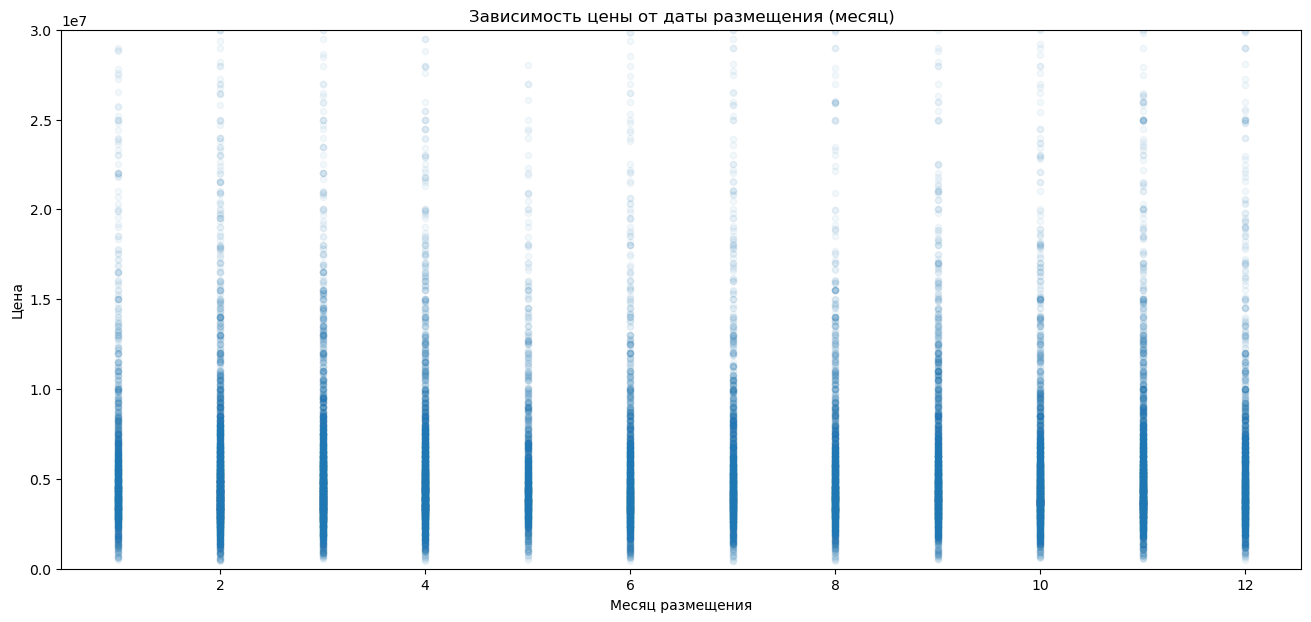

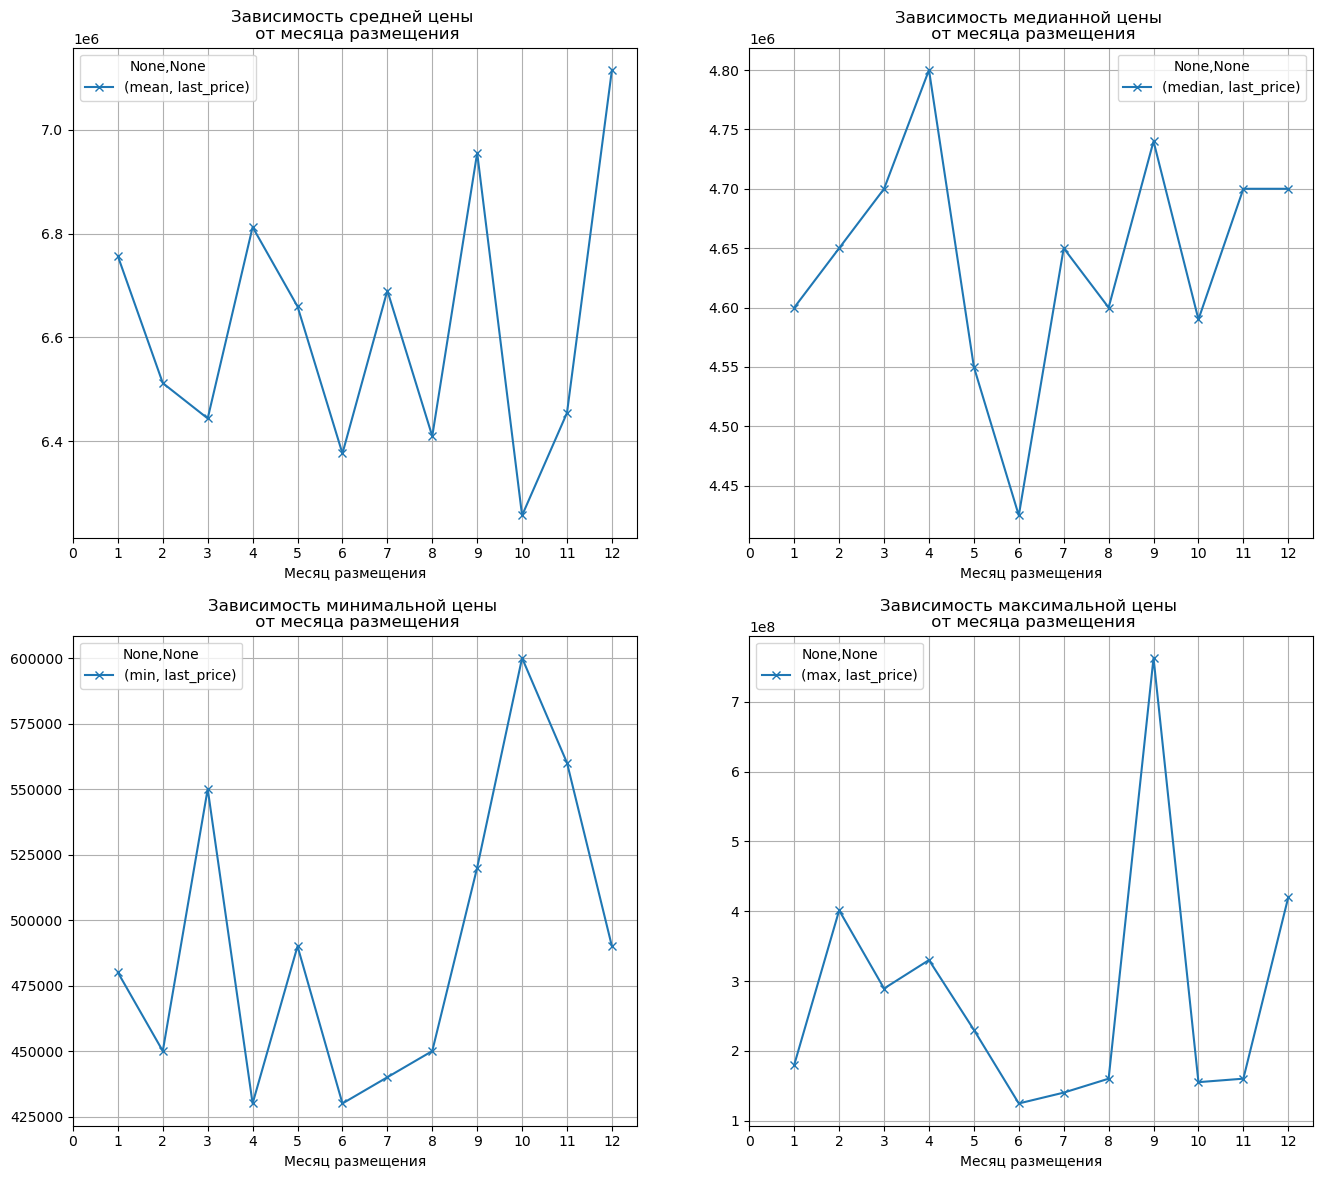

In [92]:
data.plot(x='month_publication', y='last_price', kind='scatter', alpha=0.05, figsize=(16,7))
plt.ylim([0, 3e7])
plt.xlabel('Месяц размещения')
plt.ylabel('Цена')
plt.title('Зависимость цены от даты размещения (месяц)')
print(f"Коэффициент корреляции Пирсона: {data['last_price'].corr(data['month_publication']) :.2f}")

fig, ax = plt.subplots(2,2,figsize=(16, 14))

data.pivot_table(index='month_publication', values='last_price', aggfunc=['mean']).plot(
    title='Зависимость средней цены \n от месяца размещения', style='x-', grid=True, xlabel='Месяц размещения',
    xticks=([w*1 for w in range(13)]), ax=ax[0,0])

data.pivot_table(index='month_publication', values='last_price', aggfunc=['median']).plot(
    title='Зависимость медианной цены \n от месяца размещения', style='x-', grid=True, xlabel='Месяц размещения',
    xticks=([w*1 for w in range(13)]), ax=ax[0,1])

data.pivot_table(index='month_publication', values='last_price', aggfunc=['min']).plot(
    title='Зависимость минимальной цены \n от месяца размещения', style='x-', grid=True, xlabel='Месяц размещения',
    xticks=([w*1 for w in range(13)]), ax=ax[1,0])

data.pivot_table(index='month_publication', values='last_price', aggfunc=['max']).plot(
    title='Зависимость максимальной цены \n от месяца размещения', style='x-', grid=True, xlabel='Месяц размещения',
    xticks=([w*1 for w in range(13)]), ax=ax[1,1])


Судя по диаграмме рассеяния и коэффициенту корреляции цена и месяц публикации не имеют линейную связь. Основной рост цен в марте и сентябре-октябре

Зависимость цены от даты размещения (год): <a id='analysis_price_YP'></a>

Коэффициент корреляции Пирсона: -0.04


<AxesSubplot:title={'center':'Зависимость максимальной цены \n от года размещения'}, xlabel='Год размещения'>

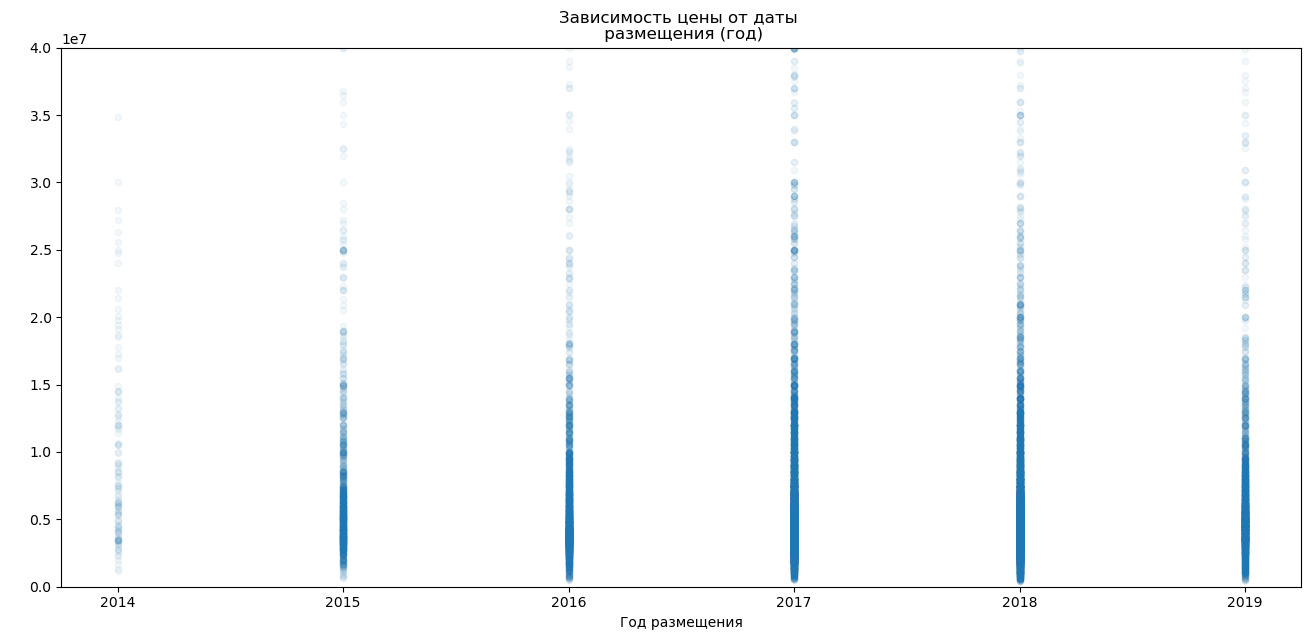

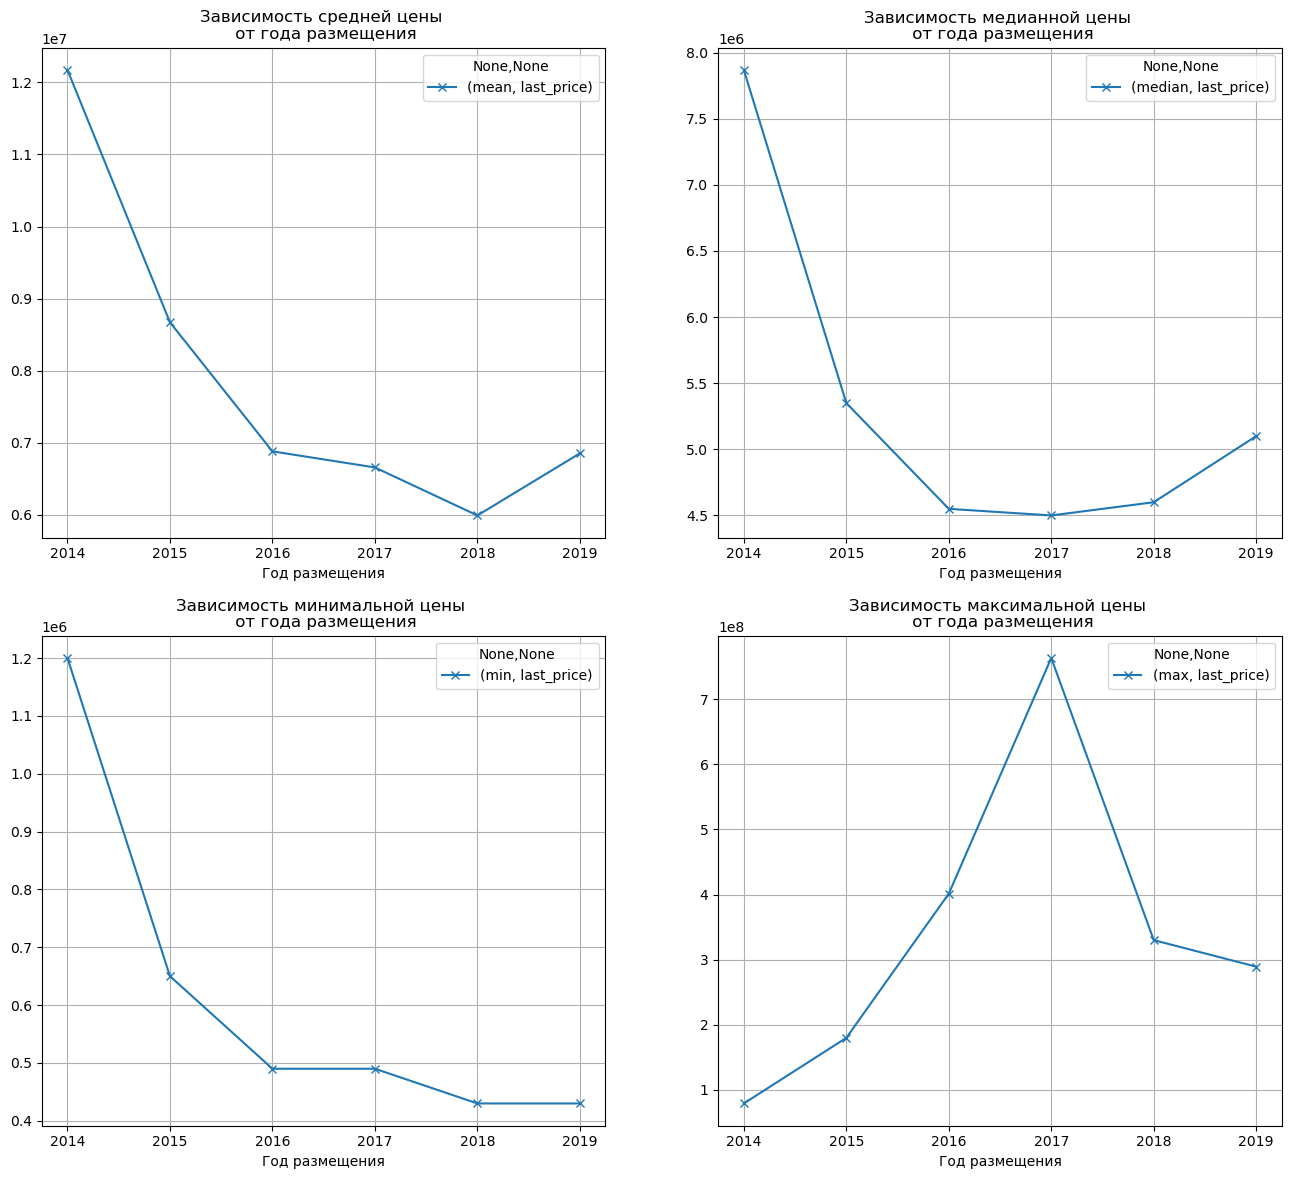

In [93]:
data.plot(x='year_publication', y='last_price', kind='scatter', alpha=0.05, figsize=(16, 7))
#plt.xlim([0, 7])
plt.ylim([0, 0.4e8])
plt.xlabel('Год размещения')
plt.ylabel(' ')
plt.title('Зависимость цены от даты \n размещения (год)')
print(f"Коэффициент корреляции Пирсона: {data['last_price'].corr(data['year_publication']) :.2f}")

fig, ax = plt.subplots(2,2,figsize=(16, 14))

data.pivot_table(index='year_publication', values='last_price', aggfunc=['mean']).plot(
    title='Зависимость средней цены \n от года размещения', style='x-', grid=True, xlabel='Год размещения', ax=ax[0,0])

data.pivot_table(index='year_publication', values='last_price', aggfunc=['median']).plot(
    title='Зависимость медианной цены \n от года размещения', style='x-', grid=True, xlabel='Год размещения', ax=ax[0,1])

data.pivot_table(index='year_publication', values='last_price', aggfunc=['min']).plot(
    title='Зависимость минимальной цены \n от года размещения', style='x-', grid=True, xlabel='Год размещения', ax=ax[1,0])

data.pivot_table(index='year_publication', values='last_price', aggfunc=['max']).plot(
    title='Зависимость максимальной цены \n от года размещения', style='x-', grid=True, xlabel='Год размещения', ax=ax[1,1])

Судя по диаграмме рассеяния и коэффициенту корреляции цена и год публикации не имеют линейную связь. Средняя и минимальная цена с годами снижалась. Максимальная цена роcла до 2017 года, затем пошла на спад

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений <a id='locality_top10'></a>

In [94]:
locality_top10 = data['locality_name'].value_counts().head(10).index
print('Топ-10 городов по количеству объявлений:')
display(locality_top10)
print()

data_locality_top10 = data.query('locality_name in @locality_top10').pivot_table(
    index='locality_name', values='price_per_square', aggfunc='mean').sort_values(by='price_per_square', ascending=False)
print('Средняя цена за квадратный метр в топ-10 городов:')
display(data_locality_top10)

print()
print('Населенный пункт с самой высокой стоимостью за квадратный метр:')
display(data_locality_top10[data_locality_top10['price_per_square']==data_locality_top10['price_per_square'].max()])

print()

print('Населенный пункт с самой низкой стоимостью за квадратный метр:')
display(data_locality_top10[data_locality_top10['price_per_square']==data_locality_top10['price_per_square'].min()])

Топ-10 городов по количеству объявлений:


Index(['санкт-петербург', 'поселок мурино', 'деревня кудрово',
       'поселок шушары', 'всеволожск', 'пушкин', 'колпино',
       'поселок парголово', 'гатчина', 'выборг'],
      dtype='object')


Средняя цена за квадратный метр в топ-10 городов:


price_per_square
locality_name                      
санкт-петербург       114546.626809
пушкин                103046.661295
деревня кудрово        95265.127386
поселок парголово      90095.368646
поселок мурино         85179.177200
поселок шушары         77971.016892
колпино                75143.736477
гатчина                68944.188556
всеволожск             68797.200563
выборг                 58364.786381


Населенный пункт с самой высокой стоимостью за квадратный метр:


price_per_square
locality_name                    
санкт-петербург     114546.626809


Населенный пункт с самой низкой стоимостью за квадратный метр:


price_per_square
locality_name                  
выборг             58364.786381

Выделим квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислим среднюю цену каждого километра: <a id='Spb_price'></a>

<AxesSubplot:title={'center':'Зависимость максимальной цены от \n удаленности от центра'}, xlabel='Удаленность (км)'>

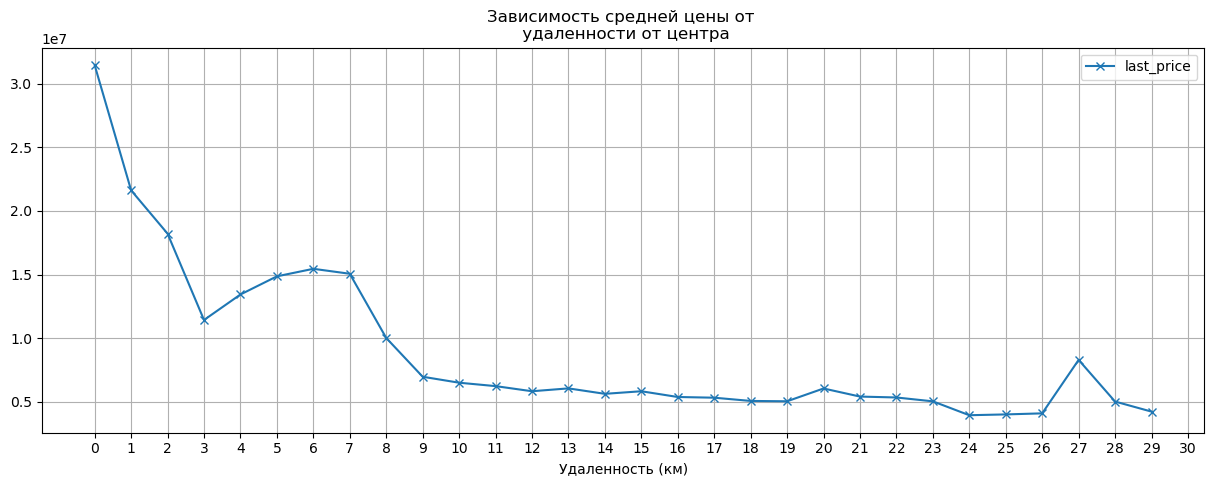

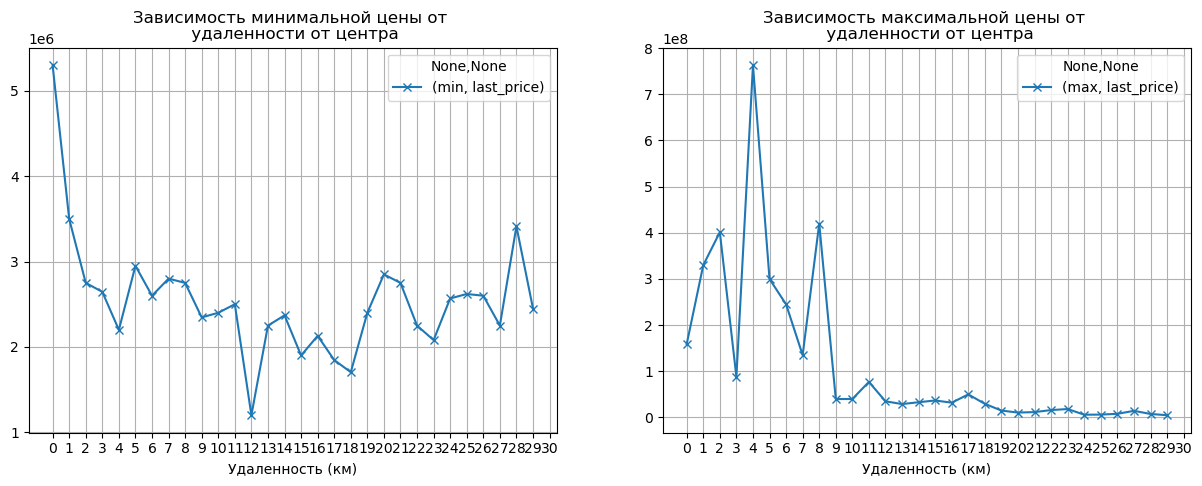

In [95]:
data_spb = data.query('locality_name == "санкт-петербург"')

data_spb.pivot_table(index='cityCenters_nearest_km', values='last_price').plot(
    title='Зависимость средней цены от \n удаленности от центра', style='x-', grid=True, xlabel='Удаленность (км)',
    xticks=([w*1 for w in range(31)]), figsize=(15,5))

fig, ax = plt.subplots(1,2,figsize=(15, 5))

data_spb.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc=['min']).plot(
    title='Зависимость минимальной цены от \n удаленности от центра', style='x-', grid=True, xlabel='Удаленность (км)',
    xticks=([w*1 for w in range(31)]), ax=ax[0])

data_spb.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc=['max']).plot(
    title='Зависимость максимальной цены от \n удаленности от центра', style='x-', grid=True, xlabel='Удаленность (км)',
    xticks=([w*1 for w in range(31)]), ax=ax[1])

Судя по граффикам, цена и удаленность от центра имеют прямую нелинейную зависимость. При большей удаленности от центра цена уменьшается. Два скачка на граффике средней цены связаны с резким увеличением максимальной стоимости на 4ом километре и ростом минимальной цены с 18го километра. Вероятно, это можно объяснить элитными новостройками в первом случае и коттеджными поселками во втором. Резкий спад минимальной цены на 12 километре, возможно, связан с КАД

### Общий вывод

Проведено исследование для поиска особенностей и зависимостей, которые существуют на рынке недвижимости.
Входные данные сервиса Яндекс Недвижимость — архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах. О каждой квартире в базе содержится два типа данных: добавленные пользователем и картографические. Например, к первому типу относятся площадь квартиры, её этаж и количество балконов, ко второму — расстояния до центра города, аэропорта и ближайшего парка. 
<br>
1. Изучены следующие параметры объектов:<br>
    * [общая площадь](#analysis_TA)
        * квартиры, имееющие общую площадь около 40 $м^2$, продают больше остальных
        * основная масса квартир имеет общую площадь от 30 $м^2$ до 70 $м^2$
    * [жилая площадь](#analysis_LA)
        * квартиры, имееющие жилую площадь около 30 $м^2$, продают больше остальных
        * основная масса квартир имеет жилую площадь от 15 $м^2$ до 50 $м^2$
    * [площадь кухни](#analysis_KA)
        * квартиры, имееющие площадь кухни около 9 $м^2$, продают больше остальных
        * основная масса квартир имеет площадь кухни от 6 $м^2$ до 25 $м^2$
    * [цена объекта](#analysis_LP)
        * квартиры, имееющие цену около 4 000 00 р., продают больше остальных
        * основная масса квартир имеет цену от 2 000 000 р. до 7 000 000 р.
    * [количество комнат](#analysis_R)
        * однокомнатные квартиры продают больше остальных
        * основная масса квартир имеет одну, две или три комнаты
        * из всех значений отсутствуют квартиры с 13-ю комнатами (возможно, является закономерностью в связи с суевериями) 
    * [высота потолков](#analysis_CH)
        * квартиры, имееющие высоту потолков 2,7 м, продают больше остальных
        * основная масса квартир имеет высоту от 2,5 м. до 3 м.
    * [этаж квартиры](#analysis_F)
        * квартиры на втором этаже продают больше остальных
        * основная масса квартир расположена с первого по девятый этажи
    * [тип этажа квартиры («первый», «последний», «другой»)](#analysis_FT)
        * подавляющее большинство квартир находится не на первом и не на последнем этажах
        * первых и последних этажей примерно равное количество
    * [общее количество этажей в доме](#analysis_FTot)
        * наиболее распространены 5 и 9 этажные дома
        * чуть менее распространены 12, 16 и 25 этажные дома
    * [расстояние до центра города в метрах](#analysis_CCN)
        * основная масса квартир находится в пределах от 10 км до 17 км от центра города.
    * [расстояние до ближайшего аэропорта](#analysis_AN)
        * основная масса квартир находится в пределах от 10 км до 55 км от ближайшего аэропорта.
    * [расстояние до ближайшего парка](#analysis_PN)
        * у основной части квартир парковая доступность в пределах 800 м
    * [день публикации объявления](#analysis_DP)
        * основная активность в будние дни
        * в выходные активность публикации примерно в два раза меньше
    * [месяц публикации объявления](#analysis_MP)<br>
        * основная активность — февраль, март, апрель и ноябрь
        * минимальная активность в январе, мае и декабре, что, вероятно, связано с праздничными днями в этих месяцах <br>
<br>
2. [Изучено, как быстро продавались квартиры](#analysis_Speed_sale) 
    * Медианное значение — 96 дней
    * Среднее значение — 182 дня
    * Половина квартир продается в течении 96 дней
    * Самый высокий показатель — 45 дней, быстрыми продажами можно считать те, которые продавались меньше 45 дней
    * Долгими продажами можно считать те, которые продавались больше 96 дней
    * Самая долгая продажа — 1580 дней <br>
<br>
3. Изучено какие факторы больше всего влияют на общую (полную) стоимость объекта? Зависит ли цена от:<br>
    * [общей площади](#analysis_price_TA)
        * Судя по диаграмме рассеяния и коэффициенту корреляции цена и общая площадь имеют линейную связь
        * При увеличении общей площади растет и цена
    * [жилой площади](#analysis_price_LA)
        * Судя по диаграмме рассеяния и коэффициенту корреляции цена и жилая площадь имеют линейную связь
        * При увеличении жилой площади растет и цена
    * [площади кухни](#analysis_price_KA)
        * Судя по диаграмме рассеяния и коэффициенту корреляции цена и площадь кухни имеют линейную связь, но менее выраженную, чем с общей и жилой площадью
        * При увеличении площади кухни растет и цена
    * [количества комнат](#analysis_price_R)
        * Судя по диаграмме рассеяния и коэффициенту корреляции цена и количество комнат имеют слабую линейную связь
        * При увеличении количества комнат растет и цена
    * [этажа, на котором расположена квартира (первый, последний, другой)](#analysis_price_FT)
        * Судя по диаграмме рассеяния цена и этажность либо имеют слабую взаимосвязь, либо более сложную (не линейную) взаимосвязь
        * Минимальная цена первого и последнего этажа равны и дешевле всех остальных этажей. Вероятно, связано с меньшей популярностью таких квартир в старом фонде из-за близости подвала и чердака
        * Максимальная цена первого этаж меньше чем остальных этажей. Максимальная цена последнего этажа выше остальных, вероятно, связано с пентхаусами
    * [даты размещения (день недели)](#analysis_price_DP)
        * Судя по диаграмме рассеяния и коэффициенту корреляции цена и день публикации не имеют линейную связь
    * [даты размещения (месяц)](#analysis_price_MP)
        * Судя по диаграмме рассеяния и коэффициенту корреляции цена и месяц публикации не имеют линейную связь
        * Основной рост цен в марте и сентябре-октябре
    * [даты размещения (год)](#analysis_price_YP)
        * Судя по диаграмме рассеяния и коэффициенту корреляции цена и год публикации не имеют линейную связь
        * Средняя и минимальная цена с годами снижались
        * Максимальная цена роcла до 2017 года, затем пошла на спад<br>
<br>
4. [Посчитана средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Определены населённые пункты с самой высокой и низкой стоимостью квадратного метра](#locality_top10) <br>
    * Средняя цена за квадратный метр в топ-10 городов:<br>
    
|**населенный пункт**|санкт-петербург|пушкин|деревня кудрово|поселок парголово|поселок мурино|поселок шушары|колпино|гатчина|всеволожск|выборг|
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|**стоимость $м^2$**|114546.626809|103046.661295|95265.127386|90095.368646|85179.177200|77971.016892|75143.736477|68944.188556|68797.200563|58364.786381|

    * Санкт-Петербург - населенный пункт с самой высокой стоимостью за квадратный метр (114546.626809)
    * Выборг - населенный пункт с самой низкой стоимостью за квадратный метр (58364.786381) 

5. [На примере квартир в Санкт-Петербурге и средней цены на каждом километре изучено, как стоимость объектов зависит от расстояния до центра города](#Spb_price)
    * Цена и удаленность от центра имеют прямую нелинейную зависимость
    * При большей удаленности от центра цена уменьшается
    * Два скачка на граффике средней цены связаны с резким увеличением максимальной стоимости на 4ом километре и ростом минимальной цены с 18го километра. Вероятно, можно объяснить элитными новостройками в первом случае и коттеджными поселками во втором
    * Резкий спад минимальной цены на 12 километре возможно связан с КАД


